In [1]:
# 以下のtrainデータから特長量を作成し、学習モデルを生成させる。
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022

In [2]:
!pip install lightGBM

In [3]:
import gc
gc.collect()

214

In [4]:
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022
# のデータを取り込む

import warnings
from sklearn.svm import SVC, LinearSVC
from sklearn import multiclass
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
import scipy.stats
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import tqdm
# 指定したディレクトリ配下のcsvデータをreadする
# is_denso = False
# train_year_list = ["2023", "2024"]
# train_path = '/home/hayato/horse_inference/data_for_train/train_data/2024/'
# if is_denso:
#     train_path = '/home/denso/horse_inference/data_for_train/train_data/2024/'

# # train dataを読み込み
# train_data = pd.read_csv(train_path + "train_data_results_2024_update.csv", encoding='utf-8')
# # データが多いと落ちるので半分だけ取得
# # train_data = train_data[:int(len(train_data)/2)]
# print("train data length {}".format(len(train_data)))

# # 勝率データ、過去のデータを取得
# horse_past_data = pd.read_csv(train_path + 'horse_results_2024.csv', encoding='utf-8')  
# # データが多いと落ちるので半分だけ取得
# # horse_past_data = horse_past_data[:int(len(horse_past_data)/2)]  
# print("horse_past_data length {}".format(len(horse_past_data)))
# horse_peds_data = pd.read_csv(train_path + 'horse_born_results_2024.csv', encoding='utf-8')
# # train_data = train_data[:100000]
# # horse_peds_data = horse_peds_data[:int(len(horse_peds_data)/2)]
# print("horse_peds_data length {}".format(len(horse_peds_data)))
# # ジョッキーの過去データを取得
# jockey_past_data = pd.read_csv(train_path + 'jockey_results_2024.csv', encoding='utf-8')
# # jockeyデータはデータの中で"累計"が含まれているものだけを抽出
# # "年度"列が"累計"の行だけを抽出
# jockey_past_data = jockey_past_data[jockey_past_data['年度'] == '累計']

In [5]:
inference_page_id = 2025050101

is_denso = False
train_year_list = ["2024"]
# train_year_list = ["2022","2023", "2024"]
train_data = pd.DataFrame()
horse_past_data = pd.DataFrame()
horse_peds_data = pd.DataFrame()
jockey_past_data = pd.DataFrame()
for year in train_year_list:
    train_path = '/home/hayato/horse_inference/data_for_train/train_data/' + year + '/'
    if is_denso:
        train_path = '/home/denso/horse_inference/data_for_train/train_data/' + year + '/'
    # train dataに各年の学習データを縦方向に結合
    train_data = pd.concat([train_data, pd.read_csv(train_path + "train_data_results_" + year + ".csv", encoding='utf-8')], axis=0)
    print("train data length {}".format(len(train_data)))

    # 勝率データ、過去のデータを取得
    horse_past_data = pd.concat([horse_past_data, pd.read_csv(train_path + 'horse_results_' + year + '.csv', encoding='utf-8')], axis=0)
    print("horse_past_data length {}".format(len(horse_past_data)))
    horse_peds_data = pd.concat([horse_peds_data, pd.read_csv(train_path + 'horse_born_results_' + year + '.csv', encoding='utf-8')], axis=0)
    print("horse_peds_data length {}".format(len(horse_peds_data)))
    # ジョッキーの過去データを取得
    jockey_past_data = pd.concat([jockey_past_data, pd.read_csv(train_path + 'jockey_results_' + year + '.csv', encoding='utf-8')], axis=0)
    # jockeyデータはデータの中で"累計"が含まれているものだけを抽出
    # "年度"列が"累計"の行だけを抽出
    jockey_past_data = jockey_past_data[jockey_past_data['年度'] == '累計']
    print("jockey_past_data length {}".format(len(jockey_past_data)))

train data length 45583
horse_past_data length 140941
horse_peds_data length 1593
jockey_past_data length 199


In [6]:
# horse_past_dataから最初のhorse_idの情報だけを抽出
first_horse_past_data = horse_past_data.drop_duplicates(subset='horse_id', keep='first')
# train_data = pd.merge(train_data, horse_peds_data, on='horse_id', how='left')

# train dataに対してhorse_past_data、horse_peds_dataをhorse_idをキーにして結合
train_data = pd.merge(train_data, first_horse_past_data, on='horse_id', how='left')
# train dataの情報を表示
print(train_data.info())
# train dataのデータ長を表示
print("train_data lenght :{}".format(len(train_data)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45583 entries, 0 to 45582
Data columns (total 49 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            45583 non-null  object 
 1   枠番            45583 non-null  int64  
 2   馬番            45583 non-null  int64  
 3   馬名            45583 non-null  object 
 4   性齢            45583 non-null  object 
 5   斤量            45583 non-null  float64
 6   騎手_x          45583 non-null  object 
 7   タイム_x         45171 non-null  object 
 8   着差_x          41837 non-null  object 
 9   単勝            45583 non-null  object 
 10  人気            45400 non-null  float64
 11  馬体重_x         45583 non-null  object 
 12  調教師           45583 non-null  object 
 13  course_len    45583 non-null  int64  
 14  weather       45583 non-null  object 
 15  race_type     45583 non-null  object 
 16  ground_state  45583 non-null  object 
 17  date          45583 non-null  object 
 18  horse_id      45583 non-nu

In [7]:
# horse_peds_dataはpeds62がhorse_idなので、peds62をhorse_idに変更
horse_peds_data = horse_peds_data.rename(columns={'peds_62': 'horse_id'})
# すごい馬の血糖情報があるけどそんなにいらないので、5頭分のpeds0からpeds5までの情報だけを取得
horse_peds_data = horse_peds_data[['horse_id', 'peds_0', 'peds_1', 'peds_2', 'peds_3', 'peds_4', 'peds_5']]
# 1pedsに色んな情報が入っているので、半角スペースまでの情報だけを取得
horse_peds_data['peds_0'] = horse_peds_data['peds_0'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_1'] = horse_peds_data['peds_1'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_2'] = horse_peds_data['peds_2'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_3'] = horse_peds_data['peds_3'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_4'] = horse_peds_data['peds_4'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_5'] = horse_peds_data['peds_5'].apply(lambda x: x.split(' ')[0])
# train dataに対してhorse_peds_dataをhorse_idをキーにして結合
train_data = pd.merge(train_data, horse_peds_data, on='horse_id', how='left')
# train dataの情報を表示
print(train_data.info())
# train dataのデータ長を表示
print("train_data lenght :{}".format(len(train_data)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45583 entries, 0 to 45582
Data columns (total 55 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            45583 non-null  object 
 1   枠番            45583 non-null  int64  
 2   馬番            45583 non-null  int64  
 3   馬名            45583 non-null  object 
 4   性齢            45583 non-null  object 
 5   斤量            45583 non-null  float64
 6   騎手_x          45583 non-null  object 
 7   タイム_x         45171 non-null  object 
 8   着差_x          41837 non-null  object 
 9   単勝            45583 non-null  object 
 10  人気            45400 non-null  float64
 11  馬体重_x         45583 non-null  object 
 12  調教師           45583 non-null  object 
 13  course_len    45583 non-null  int64  
 14  weather       45583 non-null  object 
 15  race_type     45583 non-null  object 
 16  ground_state  45583 non-null  object 
 17  date          45583 non-null  object 
 18  horse_id      45583 non-nu

In [8]:
# train_dataに対してjockey_past_dataをjockey_idをキーにして結合
# jockey_resultsから必要なjockey_idの情報だけを抽出
jockey_info = jockey_past_data[jockey_past_data['jockey_id'].isin(train_data['jockey_id'])]

train_data = pd.merge(train_data, jockey_info, on='jockey_id', how='left')
# train_data = pd.merge(train_data, jockey_past_data, on='jockey_id', how='left')
print(train_data.info())
# テスト的にtrain_dataのデータをcsvに保存
train_data.to_csv(train_path + "train_data_check.csv", index=False, encoding='utf-8')
print("train_data lenght :{}".format(len(train_data)))
train_data.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45583 entries, 0 to 45582
Data columns (total 66 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            45583 non-null  object 
 1   枠番            45583 non-null  int64  
 2   馬番            45583 non-null  int64  
 3   馬名            45583 non-null  object 
 4   性齢            45583 non-null  object 
 5   斤量            45583 non-null  float64
 6   騎手_x          45583 non-null  object 
 7   タイム_x         45171 non-null  object 
 8   着差_x          41837 non-null  object 
 9   単勝            45583 non-null  object 
 10  人気            45400 non-null  float64
 11  馬体重_x         45583 non-null  object 
 12  調教師           45583 non-null  object 
 13  course_len    45583 non-null  int64  
 14  weather       45583 non-null  object 
 15  race_type     45583 non-null  object 
 16  ground_state  45583 non-null  object 
 17  date          45583 non-null  object 
 18  horse_id      45583 non-nu

,枠番,馬番,斤量,人気,course_len,horse_id,jockey_id,race_id,R,映 像,...,厩舎 ｺﾒﾝﾄ,備考,賞金,1着,2着,3着,4着〜,騎乗 回数,重賞 出走,重賞 勝利
count,45583.000000,45583.000000,45583.000000,45400.000000,45583.000000,4.558300e+04,45583.000000,4.558300e+04,45512.000000,0.0,...,0.0,0.0,15518.000000,45583.000000,45583.000000,45583.000000,45583.000000,45583.000000,45583.000000,45583.000000
mean,4.766119,7.646294,55.757113,7.620815,1655.651668,2.020486e+09,1469.703245,2.024060e+11,7.358587,NaN,...,NaN,NaN,418.199091,575.332712,561.660466,549.030779,5255.593182,6941.617138,315.055372,23.793278
std,2.272328,4.387999,1.803266,4.374613,412.222632,1.304144e+06,1199.770167,2.393364e+06,3.343857,NaN,...,NaN,NaN,1268.604559,713.196082,617.666454,559.915548,4376.217866,6037.650252,400.332892,49.323949
min,1.000000,1.000000,49.000000,1.000000,1000.000000,2.012101e+09,422.000000,2.024010e+11,1.000000,NaN,...,NaN,NaN,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,3.000000,4.000000,55.000000,4.000000,1400.000000,2.020101e+09,1102.000000,2.024040e+11,5.000000,NaN,...,NaN,NaN,42.000000,95.000000,102.000000,116.000000,1735.000000,2043.000000,27.000000,0.000000
50%,5.000000,7.000000,56.000000,7.000000,1600.000000,2.021102e+09,1161.000000,2.024060e+11,8.000000,NaN,...,NaN,NaN,140.000000,312.000000,344.000000,364.000000,3722.000000,4769.000000,169.000000,8.000000
75%,7.000000,11.000000,57.000000,11.000000,1800.000000,2.021106e+09,1191.000000,2.024080e+11,10.000000,NaN,...,NaN,NaN,460.000000,803.000000,850.000000,928.000000,8699.000000,11232.000000,467.000000,23.000000
max,8.000000,18.000000,65.000000,18.000000,4250.000000,2.022110e+09,5667.000000,2.024100e+11,12.000000,NaN,...,NaN,NaN,50340.200000,4559.000000,3451.000000,2772.000000,18791.000000,24936.000000,2047.000000,363.000000


In [9]:
# train_dataの重複をrace_id, horse_idで削除
train_data = train_data.drop_duplicates(subset=["race_id", "horse_id"], keep='first')
# 重複をassertで確認
assert train_data.duplicated(subset=["race_id", "horse_id"]).sum() == 0

# oddsだけ前処理の前に準備しておく
train_data['単勝'] = train_data['単勝'].replace('---', 100)
train_data['odds'] = train_data['単勝'].apply(lambda x: float(x))   
train_data_for_ranking = train_data.copy()


In [10]:

inference_data_path = "/home/hayato/horse_inference/inference/" + str(inference_page_id) + "/add_dynamic_data/"
if is_denso:
    inference_data_path = "/home/denso/horse_inference/inference/" + str(inference_page_id) + "/add_dynamic_data/"

In [11]:
train_data


,着順,枠番,馬番,馬名,性齢,斤量,騎手_x,タイム_x,着差_x,単勝,...,2着,3着,4着〜,騎乗 回数,重賞 出走,重賞 勝利,勝率,連対率,複勝率,odds
0,1,5,5,ポッドベイダー,牡2,55.0,佐々木大,1:08.8,NaN,1.2,...,136,166,1430,1889,35,3,8.3％,15.5％,24.3％,1.2
1,2,2,2,ニシノクードクール,牝2,55.0,武藤雅,1:09.1,1.3/4,10.2,...,219,227,3273,3908,78,0,4.8％,10.4％,16.2％,10.2
2,3,3,3,ロードヴェルト,牡2,55.0,横山武史,1:09.4,1.3/4,7.9,...,555,539,3899,5653,272,23,11.7％,21.5％,31.0％,7.9
3,4,1,1,ルージュアマリア,牝2,55.0,永野猛蔵,1:10.0,3.1/2,5.9,...,139,130,2121,2501,33,0,4.4％,10.0％,15.2％,5.9
4,5,4,4,ロードヴァルカン,牡2,54.0,角田大河,1:10.1,クビ,21.3,...,98,110,1295,1593,35,1,5.6％,11.8％,18.7％,21.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45578,11,4,7,グランデスフィーダ,牡4,58.0,荻野極,1:46.6,2,32.3,...,211,239,3347,4023,118,2,5.6％,10.9％,16.8％,32.3
45579,12,6,10,アメリカンチーフ,牡3,54.0,西塚洸二,1:46.8,1.1/4,51.0,...,64,58,930,1122,9,0,6.2％,11.9％,17.1％,51.0
45580,13,5,8,シブースト,牝4,53.0,吉村誠之,1:49.0,大,167.0,...,36,43,496,613,4,0,6.2％,12.1％,19.1％,167.0
45581,14,8,15,ペイシャコパ,牝3,50.0,河原田菜,1:49.1,3/4,85.7,...,27,33,643,723,1,0,2.8％,6.5％,11.1％,85.7


In [12]:
train_data.info()
train_data_mlp = train_data.copy()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45583 entries, 0 to 45582
Data columns (total 67 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            45583 non-null  object 
 1   枠番            45583 non-null  int64  
 2   馬番            45583 non-null  int64  
 3   馬名            45583 non-null  object 
 4   性齢            45583 non-null  object 
 5   斤量            45583 non-null  float64
 6   騎手_x          45583 non-null  object 
 7   タイム_x         45171 non-null  object 
 8   着差_x          41837 non-null  object 
 9   単勝            45583 non-null  object 
 10  人気            45400 non-null  float64
 11  馬体重_x         45583 non-null  object 
 12  調教師           45583 non-null  object 
 13  course_len    45583 non-null  int64  
 14  weather       45583 non-null  object 
 15  race_type     45583 non-null  object 
 16  ground_state  45583 non-null  object 
 17  date          45583 non-null  object 
 18  horse_id      45583 non-nu

In [13]:
# 前処理
def preprocess(train_data, is_ranking=False, is_mlp=False):
    # 不要な特長量であるUnnamed: 0、class_list_in_raceを削除する
    # train_data = train_data.drop(['馬名','騎手_x', '人気',"調教師","枠番"], axis=1)
    # これはlightGBMによる成約であり、0からクラス数-1の目的変数にラベリングしなければならない

    # 着順はobject型であるため、int型に変換する。"除"、"中"のような文字列だった場合は100に変換する
    train_data['着順'] = train_data['着順'].replace('除', 100).replace('中', 100).replace('取', 100).replace('計不', 100)
    # 着順が計不の場合は100に変換する
    train_data['着順'] = train_data['着順'].replace('計不', 100)
    # 着順列の値を処理して数値部分のみを抽出
    train_data['着順'] = train_data['着順'].apply(lambda x: int(x.split('(')[0]) if isinstance(x, str) else x)
    train_data['着順'] = train_data['着順'].astype(int)
    train_data['goal_number'] = train_data['着順']

    if not is_ranking:
        # ランキング学習でない場合は通常のグルーピング
        # 目的変数であるgoal_numberをグルーピングする。1であれば0、2と3は1にまとめる、4以上は2にまとめる
        train_data['goal_number'] = train_data['goal_number'].replace(
            {1: 0, 2: 1, 3: 1}
        ).apply(lambda x: 2 if x >= 4 else x)
    else:
        # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
        # goal numberをスコア化
        # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
        # ->評価指標(NDCG)に合わせて指数関数的にスコアをつける
        train_data['goal_number_replace'] = train_data['goal_number'].apply(
            # lambda x: 10 if x == 1 else (5 if x == 2 else (2 if x == 3 else 0)))
            lambda x: 30 if x == 1 else (3 if x == 2 else (1 if x == 3 else 0)))
    
    # inference に合わせて前処理を実施
    # 性齢の1文字から性別を取得しhorse_sexへ、2文字目以降から年齢を取得しhorse_ageへ格納する
    train_data['horse_sex'] = train_data['性齢'].apply(lambda x: x[0])
    train_data['horse_age'] = train_data['性齢'].apply(lambda x: int(x[1:]))
    # 馬体重_xから体重と、()内の増減を取得する
    # 馬体重が計不の場合は500
    train_data['馬体重_x'] = train_data['馬体重_x'].replace('計不', '500(0)')
    train_data['horse_weight'] = train_data['馬体重_x'].apply(lambda x: int(x.split('(')[0]))
    train_data['weight_change'] = train_data['馬体重_x'].apply(lambda x: int(x.split('(')[1].replace(')', '')))
    # 斤量を取得しhandiに格納する
    train_data['handi'] = train_data['斤量'].apply(lambda x: int(x))
    # course_lenを取得しdistanceに格納する
    train_data['distance'] = train_data['course_len'].apply(lambda x: int(x))
    # race_typeを取得し1文字目を取得しconditionに格納する
    train_data['condition'] = train_data['race_type'].apply(lambda x: x[0])
    # 馬番を取得しumabanに格納する
    train_data['umaban'] = train_data['馬番'].apply(lambda x: int(x))
    # 単勝を取得しoddsに格納する
    # 単勝が---の場合は100に変換する
    train_data['単勝'] = train_data['単勝'].replace('---', 100)
    train_data['odds'] = train_data['単勝'].apply(lambda x: float(x))
    # oddsの逆数を取得し、odds_invに格納する
    train_data['odds_inv'] = train_data['odds'].apply(lambda x: 1 / x)

    # タイム_yは1:34.0のような形式なので、秒に変換する
    # nanの場合は100に変換する
    # 'タイム_y'列の値を文字列に変換し、NaN値を無視して処理を行う
    train_data['タイム_y'] = train_data['タイム_y'].astype(str).apply(
        lambda x: int(x.split(':')[0]) * 60 + float(x.split(':')[1]) if ':' in x else np.nan
    )

    # 'ペース'列の値を文字列に変換し、NaN値を無視して処理を行う
    train_data['pace1'] = train_data['ペース'].astype(str).apply(
        lambda x: float(x.split('-')[0]) if '-' in x else np.nan
    )
    train_data['pace2'] = train_data['ペース'].astype(str).apply(
        lambda x: float(x.split('-')[1]) if '-' in x else np.nan
    )

    # 馬体重_yは480(+2)のような形式なので、体重と増減を分ける
    train_data['馬体重_y'] = train_data['馬体重_y'].replace('計不', '500(0)')
    train_data['horse_weight_y'] = train_data['馬体重_y'].apply(lambda x: int(x.split('(')[0]))
    # 'weight_change_y'列を作成し、'馬体重_y'列の値を処理
    train_data['weight_change_y'] = train_data['馬体重_y'].apply(
        lambda x: int(x.split('(')[1].replace(')', '')) if '(' in x else np.nan
    )

    # '連対率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    train_data['連対率'] = train_data['連対率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) else x
    )

    # '勝率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    train_data['勝率'] = train_data['勝率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) else x
    )

    # '複勝率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    train_data['複勝率'] = train_data['複勝率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) else x
    )
    # columnの名前を確認し、:や 、"、'がある場合は_に置き換える
    # train_data.columns = train_data.columns.str.replace(":", "_")
    # train_data.columns = train_data.columns.str.replace(",", "_")
    # train_data.columns = train_data.columns.str.replace("'", "_")
    # train_data.columns = train_data.columns.str.replace('"', "_")
    # train_data.columns = train_data.columns.str.replace(" ", "_")

    # train dataのカラム情報を表示
    print(train_data.columns)

    # 学習、推論データの特長量を定義する
    target_feature = 'goal_number'
    features = [
        'distance',
        'condition',
        'umaban', # 100%になったし、そもそも不要なのでコメントアウト
        'horse_age',
        'horse_sex',
        # 'horse_weight', # 馬の体重は引っ張ってこれないのでコメントアウト
        # 'weight_change',
        'handi',
        # 'odds',
        "odds_inv",
        # ここまではtrain_resultとinferenceから抽出できる共通データ

        # ここからは馬の過去データから抽出できるので必要な情報を追加する
        '天 気',
        '頭 数',
        '枠番',
        '馬番',
        # 'オ ッ ズ',
        '人気',
        # '着順', # 目的変数なので削除する
        '斤量',
        '距離',
        '馬 場',
        'タイム_y',
        'pace1',
        'pace2',
        '上り',
        'horse_weight_y',
        'weight_change_y',
        '賞金',
        # # ここからはジョッキーの過去データから抽出できるので必要な情報を追加する
        '1着',
        '2着',
        '3着',
        '4着〜',
        '騎乗 回数',
        '重賞 出走',
        '重賞 勝利',
        '勝率',
        '連対率',
        '複勝率',
        'peds_0',   # 血統情報を学習データに入れると結果が悪くなったのでコメントアウト
        'peds_1',
        'peds_2',
        'peds_3',
        'peds_4',
        'peds_5',
    ]
    if is_mlp:
        # race idを追加する
        features += ["race_id"]
        features += ["着順"]
    # 特長量を抽出する
    if is_ranking:
        additional_features = ['log_odds', 'normalized_odds', 'zscore_odds', 'odds_rank', 'odds_std']
        # additional_features = ['odds_std', "odds_diff-1-2","odds_diff-1-3"]
        # additinal_features = []
        train_data = train_data[features + [target_feature] + ['goal_number_replace'] + additional_features]
        # train_data = train_data[features + [target_feature] + ['goal_number_replace'] ]
    else:
        train_data = train_data[features + [target_feature]]
    # inference_dataの特長量のobject型は、LabelEncoderで数値に変換する
    # object型の特長量を確認する
    object_columns = train_data.select_dtypes(include='object').columns
    object_columns
    for column in object_columns:
        le = LabelEncoder()
        # object型は別のラベル名にてラベルエンコーディングする
        train_data[column] = le.fit_transform(train_data[column])
    # 学習データが大きすぎるので、train_dataの上から1000行を取得して学習データとする
    # if not is_ranking:
    #     train_data = train_data[:50000]
    print(train_data.info())
    return train_data

train_data = preprocess(train_data)
# mlp用にコピーする
train_data_mlp = preprocess(train_data_mlp, is_mlp=True)   


Index(['着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手_x', 'タイム_x', '着差_x', '単勝', '人気',
       '馬体重_x', '調教師', 'course_len', 'weather', 'race_type', 'ground_state',
       'date', 'horse_id', 'jockey_id', 'race_id', '日付', '開催', '天 気', 'R',
       'レース名', '映 像', '頭 数', '枠 番', '馬 番', 'オ ッ ズ', '人 気', '着 順', '騎手_y',
       '斤 量', '距離', '馬 場', '馬場 指数', 'タイム_y', '着差_y', 'ﾀｲﾑ 指数', '通過', 'ペース',
       '上り', '馬体重_y', '厩舎 ｺﾒﾝﾄ', '備考', '勝ち馬 (2着馬)', '賞金', 'peds_0', 'peds_1',
       'peds_2', 'peds_3', 'peds_4', 'peds_5', '年度', '1着', '2着', '3着', '4着〜',
       '騎乗 回数', '重賞 出走', '重賞 勝利', '勝率', '連対率', '複勝率', 'odds', 'goal_number',
       'horse_sex', 'horse_age', 'horse_weight', 'weight_change', 'handi',
       'distance', 'condition', 'umaban', 'odds_inv', 'pace1', 'pace2',
       'horse_weight_y', 'weight_change_y'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45583 entries, 0 to 45582
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------     

/tmp/ipykernel_20174/4287171729.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_20174/4287171729.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_20174/4287171729.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Index(['着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手_x', 'タイム_x', '着差_x', '単勝', '人気',
       '馬体重_x', '調教師', 'course_len', 'weather', 'race_type', 'ground_state',
       'date', 'horse_id', 'jockey_id', 'race_id', '日付', '開催', '天 気', 'R',
       'レース名', '映 像', '頭 数', '枠 番', '馬 番', 'オ ッ ズ', '人 気', '着 順', '騎手_y',
       '斤 量', '距離', '馬 場', '馬場 指数', 'タイム_y', '着差_y', 'ﾀｲﾑ 指数', '通過', 'ペース',
       '上り', '馬体重_y', '厩舎 ｺﾒﾝﾄ', '備考', '勝ち馬 (2着馬)', '賞金', 'peds_0', 'peds_1',
       'peds_2', 'peds_3', 'peds_4', 'peds_5', '年度', '1着', '2着', '3着', '4着〜',
       '騎乗 回数', '重賞 出走', '重賞 勝利', '勝率', '連対率', '複勝率', 'odds', 'goal_number',
       'horse_sex', 'horse_age', 'horse_weight', 'weight_change', 'handi',
       'distance', 'condition', 'umaban', 'odds_inv', 'pace1', 'pace2',
       'horse_weight_y', 'weight_change_y'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45583 entries, 0 to 45582
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------     

/tmp/ipykernel_20174/4287171729.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_20174/4287171729.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_20174/4287171729.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [14]:
# 特長量の前処理①対数変換
def log_transform(train_data):
    # 対数変換を行う特長量を定義する。対象はスケールの大きいもの、右に裾が長いもの、指数的に増加するものがある。
    log_features = [
        # 'distance',
        'odds',
        'オ ッ ズ',
        # 'タイム_y',
        # '4着〜',
        # '騎乗 回数'
    ]
    # 対数変換を行う
    for feature in log_features:
        train_data[feature] = np.log1p(train_data[feature])
    return train_data

# train_data = log_transform(train_data)

In [15]:
# 特長量の前処理②標準化
def standard_scaler(train_data):
    # 標準化を行う特長量を定義する。標準化は特長量のスケールを揃えるために行う。ラベルエンコーディングされた特長量以外は基本実施
    standard_features = [
        'distance',
        # 'condition',
        # 'umaban', # 100%になったし、そもそも不要なのでコメントアウト
        # 'horse_age',
        # 'horse_sex',
        # 'horse_weight',
        # 'weight_change',
        'handi',
        # 'odds',
        # ここまではtrain_resultとinferenceから抽出できる共通データ

        # ここからは馬の過去データから抽出できるので必要な情報を追加する
        # '天 気',
        '頭 数',
        # '枠番',
        # '馬番',
        # 'オ ッ ズ',
        '人気',
        # '着順', # 目的変数なので削除する
        '斤量',
        # '距離',  # ラベルなので削除
        # '馬 場',
        'タイム_y',
        'pace1',
        'pace2',
        '上り',
        'horse_weight_y',
        'weight_change_y',
        '賞金',
        # # ここからはジョッキーの過去データから抽出できるので必要な情報を追加する
        '1着',
        '2着',
        '3着',
        '4着〜',
        '騎乗 回数',
        '重賞 出走',
        '重賞 勝利',
        '勝率',
        '連対率',
        '複勝率',
    ]
    # 標準化実施
    scaler = StandardScaler()
    train_data[standard_features] = scaler.fit_transform(train_data[standard_features])
    return train_data

train_data = standard_scaler(train_data)
    

/tmp/ipykernel_20174/2331473695.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[standard_features] = scaler.fit_transform(train_data[standard_features])


In [16]:
train_data.info()

# # train_dataの中からgoal_numberとついたすべての名前の特長量を削除する
# train_data = train_data.drop(train_data.filter(like='goal_number').columns, axis=1)

# #inference_dataも同様にgoal_numbearとついたすべての名前の特長量を削除する
# inference_data = inference_data.drop(inference_data.filter(like='goal_number').columns, axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45583 entries, 0 to 45582
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         45583 non-null  float64
 1   condition        45583 non-null  int64  
 2   umaban           45583 non-null  int64  
 3   horse_age        45583 non-null  int64  
 4   horse_sex        45583 non-null  int64  
 5   handi            45583 non-null  float64
 6   odds_inv         45583 non-null  float64
 7   天 気              45583 non-null  int64  
 8   頭 数              45576 non-null  float64
 9   枠番               45583 non-null  int64  
 10  馬番               45583 non-null  int64  
 11  人気               45400 non-null  float64
 12  斤量               45583 non-null  float64
 13  距離               45583 non-null  int64  
 14  馬 場              45583 non-null  int64  
 15  タイム_y            44690 non-null  float64
 16  pace1            45488 non-null  float64
 17  pace2       

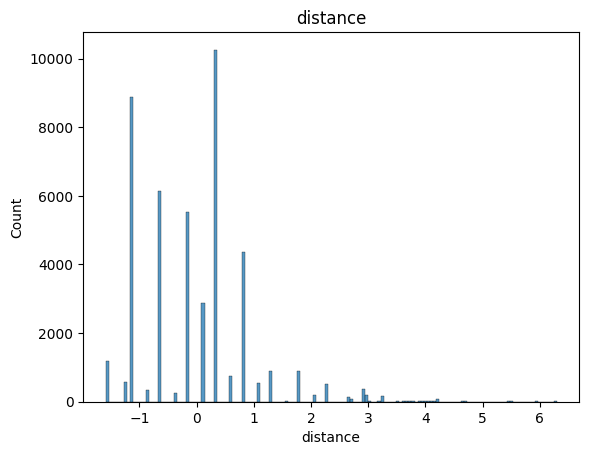

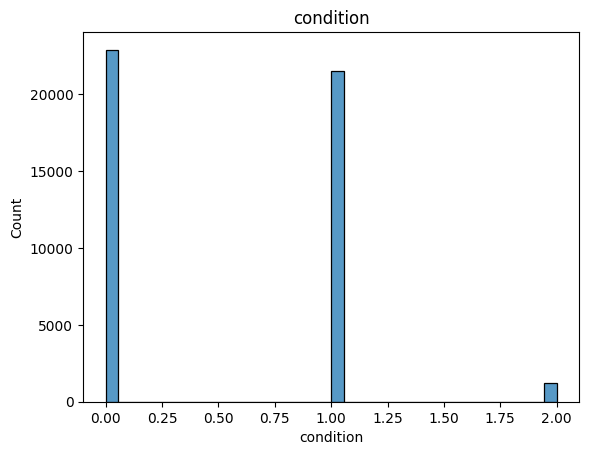

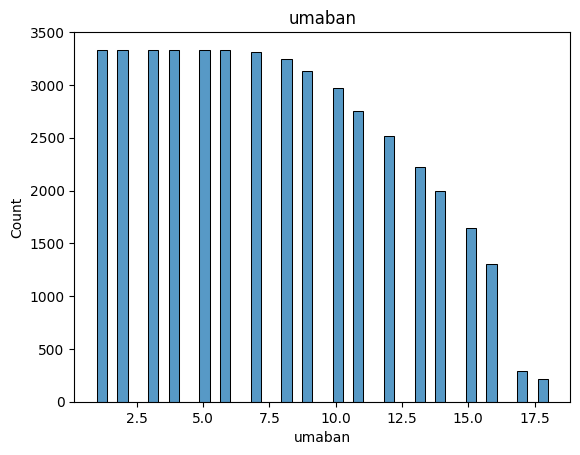

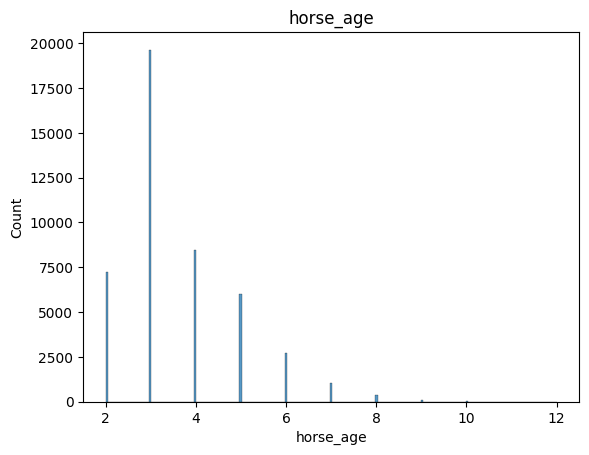

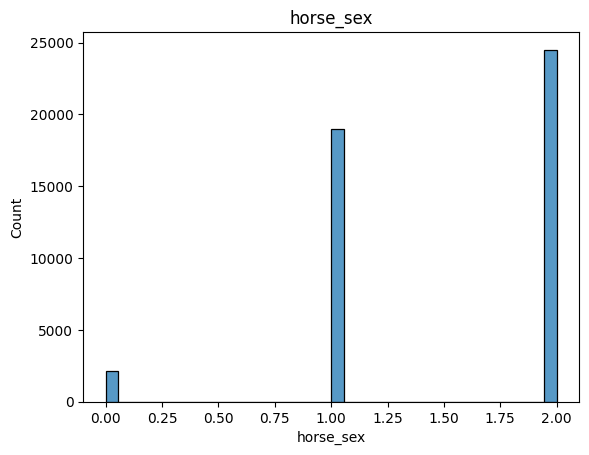

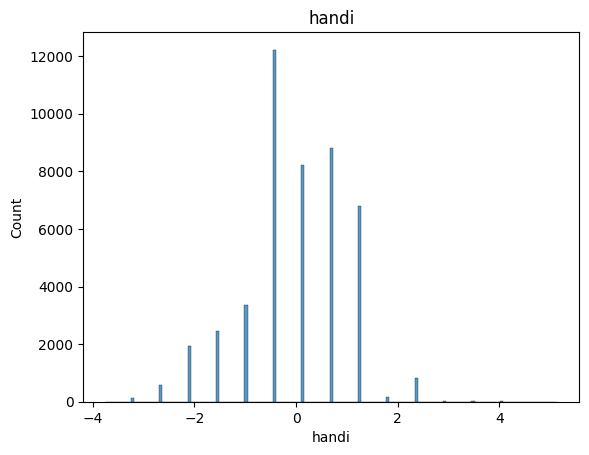

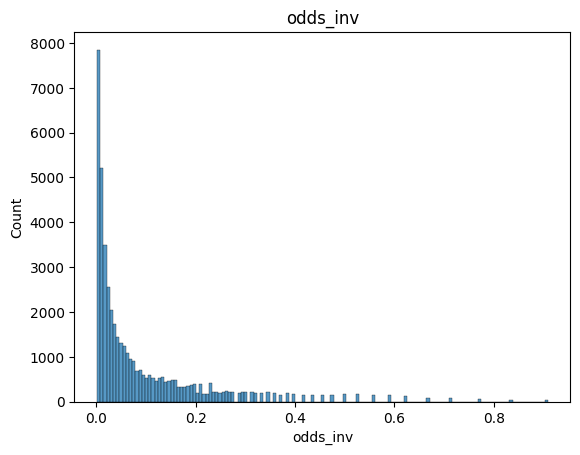

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


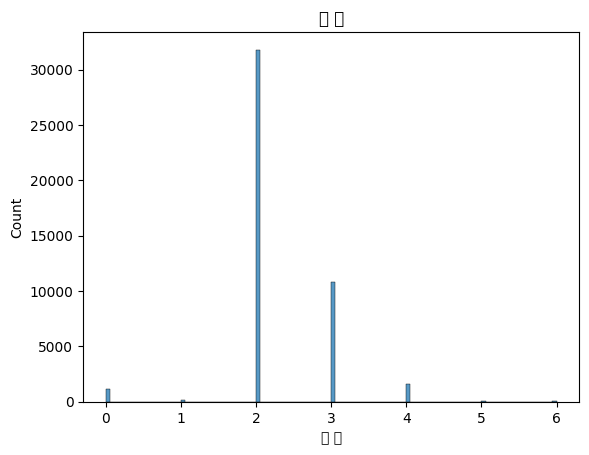

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38957 (\N{CJK UNIFIED IDEOGRAPH-982D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


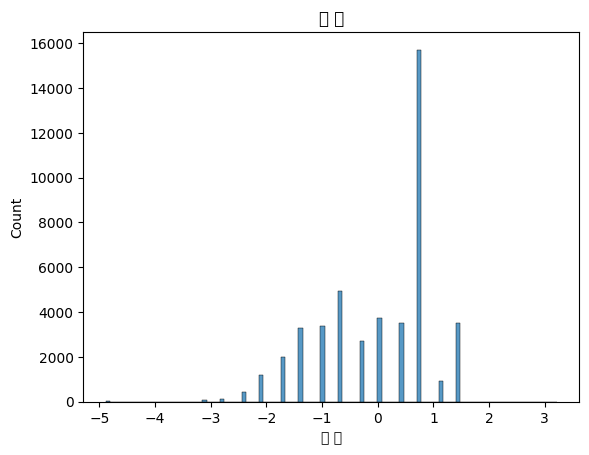

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26528 (\N{CJK UNIFIED IDEOGRAPH-67A0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30058 (\N{CJK UNIFIED IDEOGRAPH-756A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


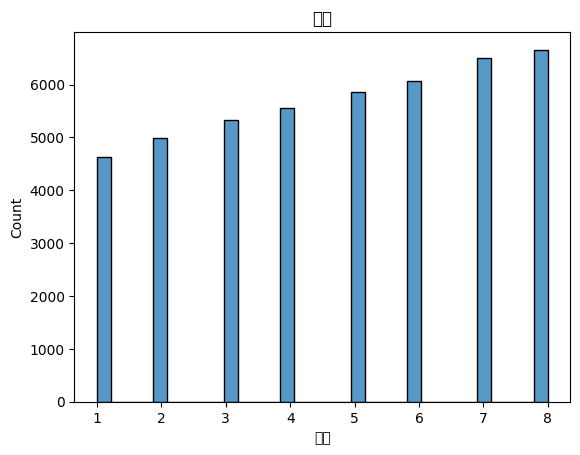

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39340 (\N{CJK UNIFIED IDEOGRAPH-99AC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30058 (\N{CJK UNIFIED IDEOGRAPH-756A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


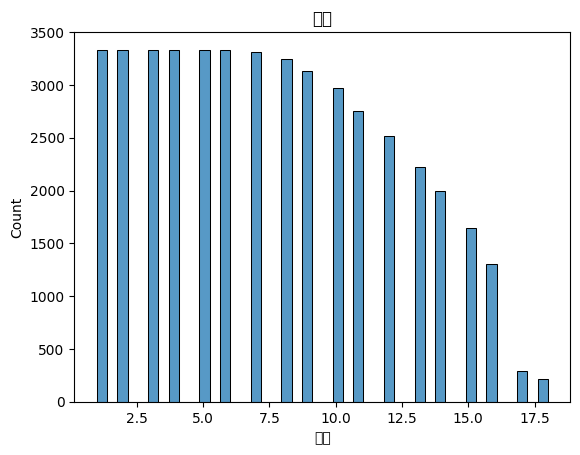

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


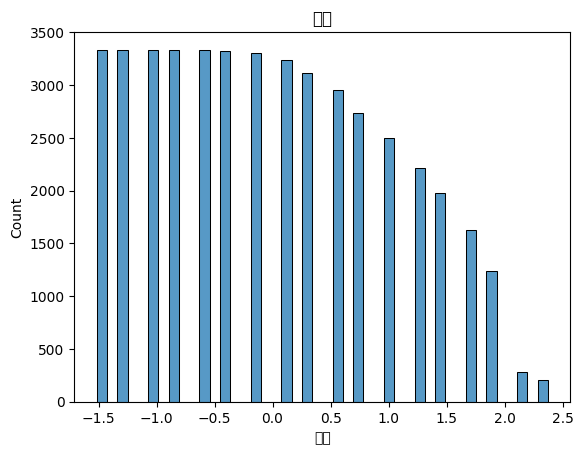

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26020 (\N{CJK UNIFIED IDEOGRAPH-65A4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


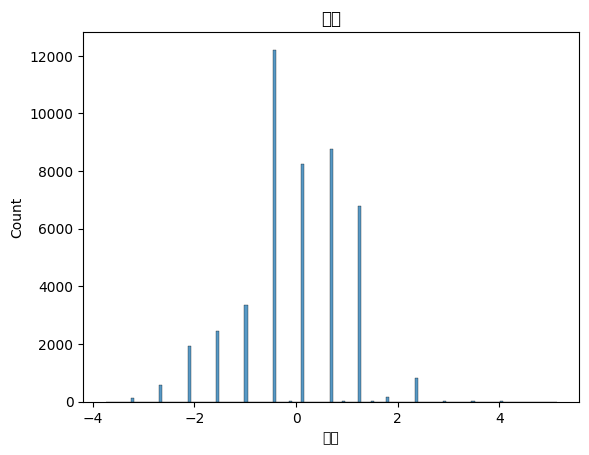

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


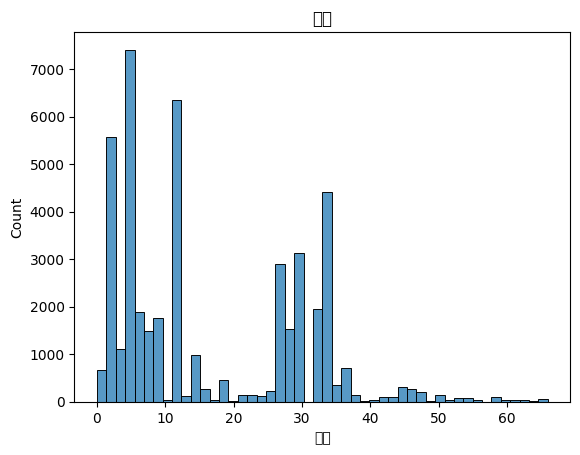

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39340 (\N{CJK UNIFIED IDEOGRAPH-99AC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22580 (\N{CJK UNIFIED IDEOGRAPH-5834}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


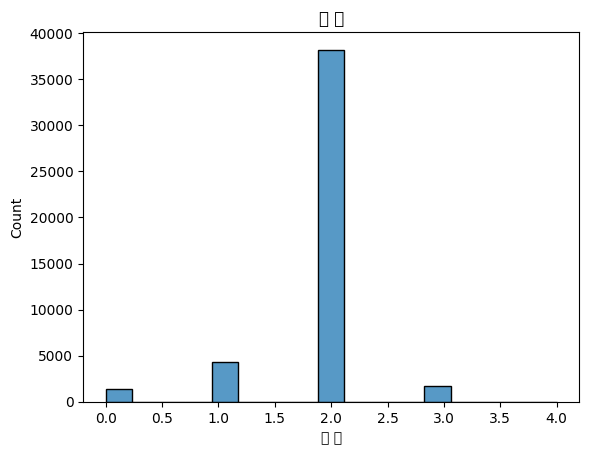

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12512 (\N{KATAKANA LETTER MU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


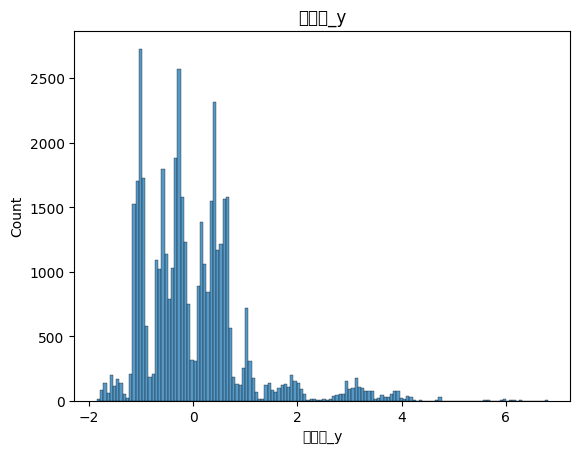

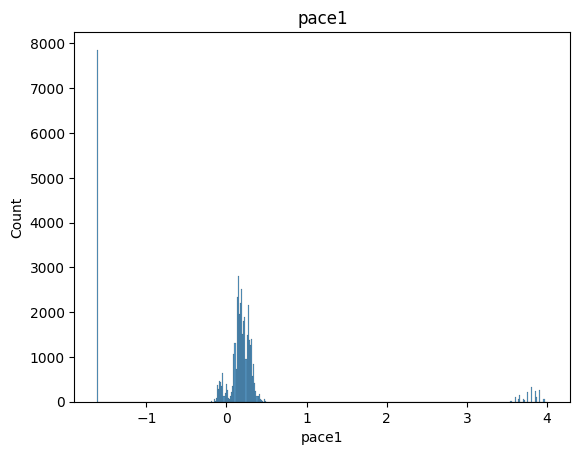

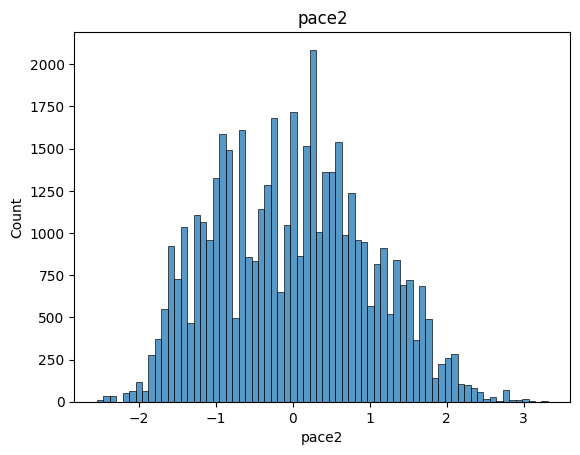

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12426 (\N{HIRAGANA LETTER RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


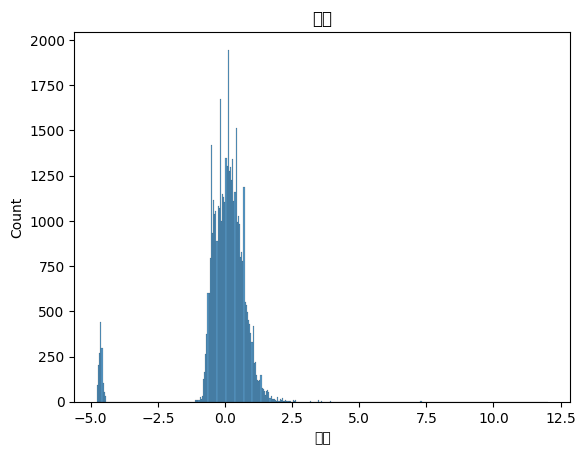

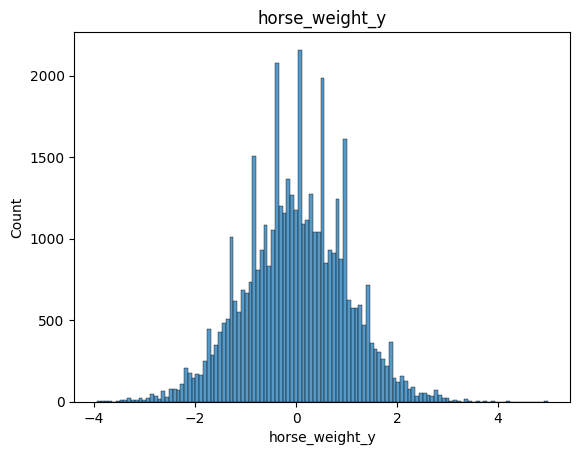

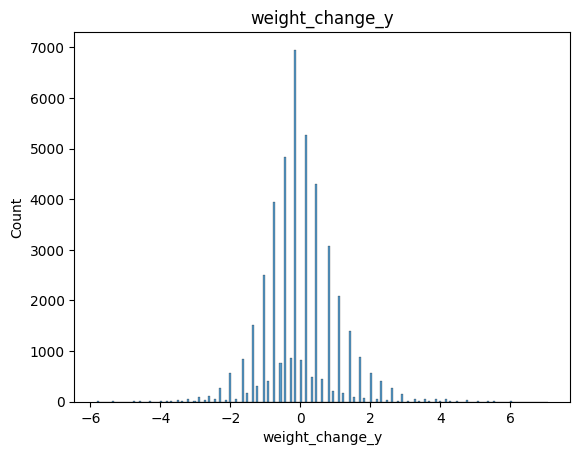

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36062 (\N{CJK UNIFIED IDEOGRAPH-8CDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


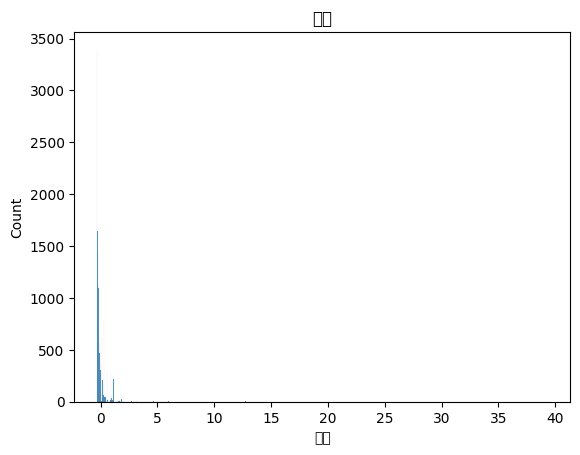

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


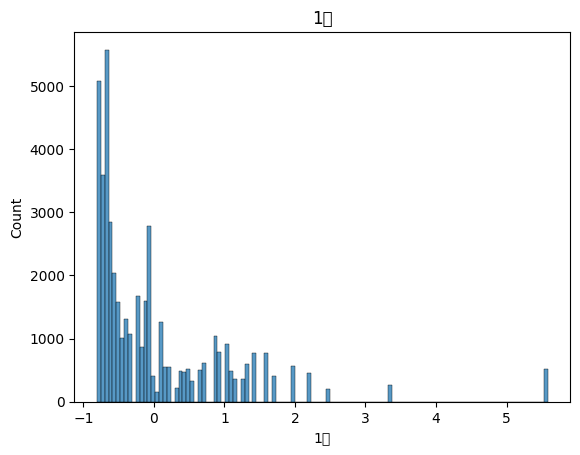

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


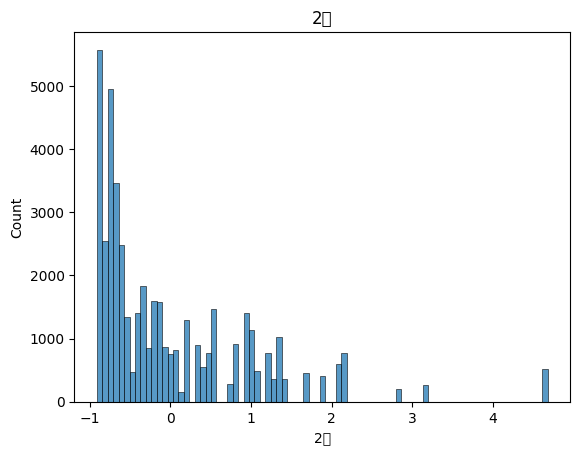

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


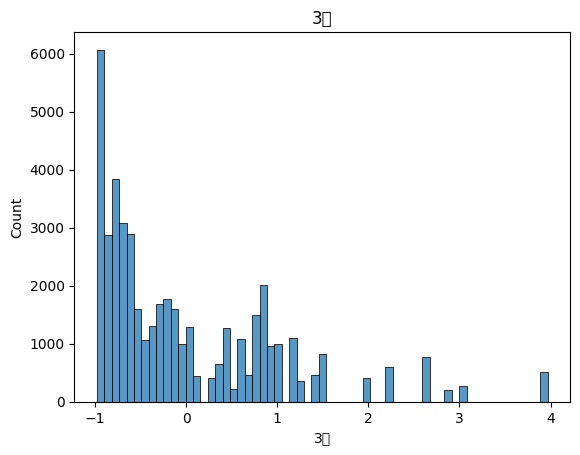

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12316 (\N{WAVE DASH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


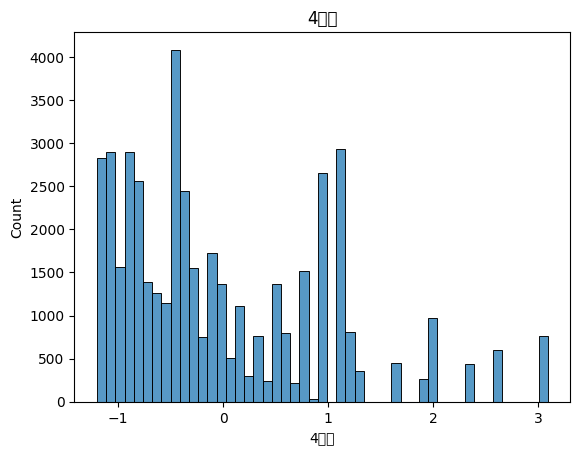

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39438 (\N{CJK UNIFIED IDEOGRAPH-9A0E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20055 (\N{CJK UNIFIED IDEOGRAPH-4E57}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


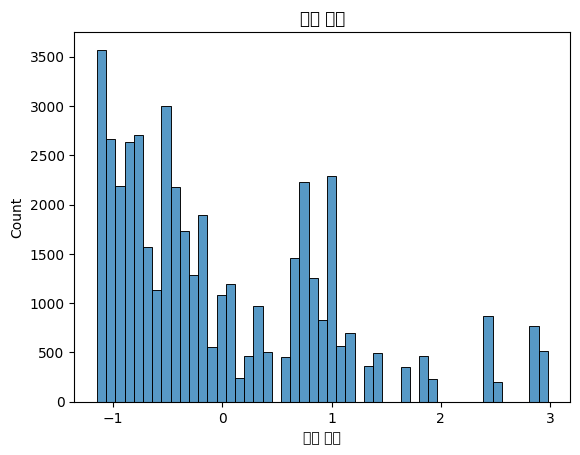

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36062 (\N{CJK UNIFIED IDEOGRAPH-8CDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36208 (\N{CJK UNIFIED IDEOGRAPH-8D70}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


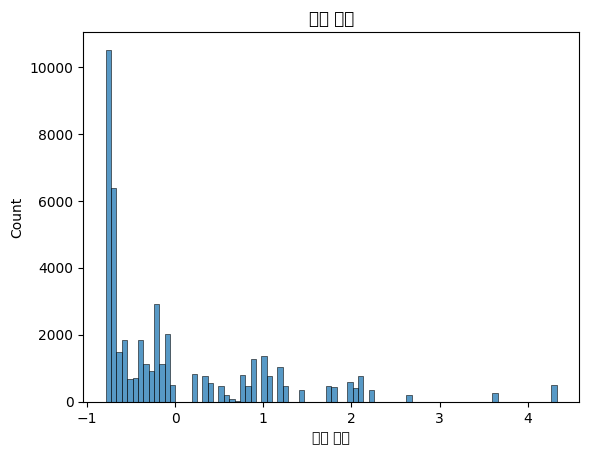

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36062 (\N{CJK UNIFIED IDEOGRAPH-8CDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21213 (\N{CJK UNIFIED IDEOGRAPH-52DD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21033 (\N{CJK UNIFIED IDEOGRAPH-5229}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


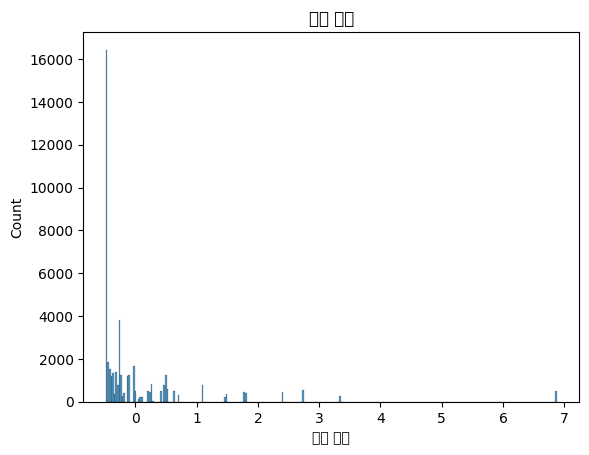

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21213 (\N{CJK UNIFIED IDEOGRAPH-52DD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


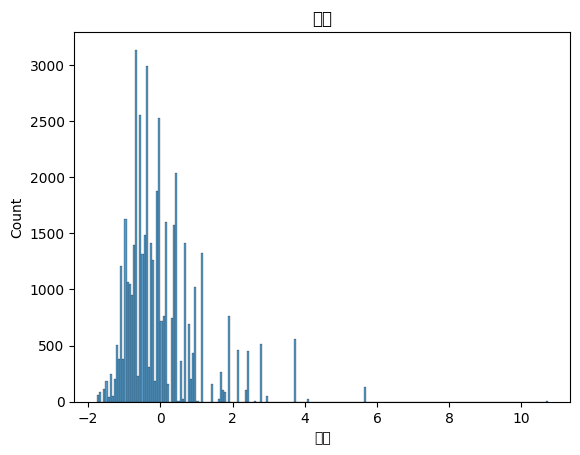

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36899 (\N{CJK UNIFIED IDEOGRAPH-9023}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23550 (\N{CJK UNIFIED IDEOGRAPH-5BFE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


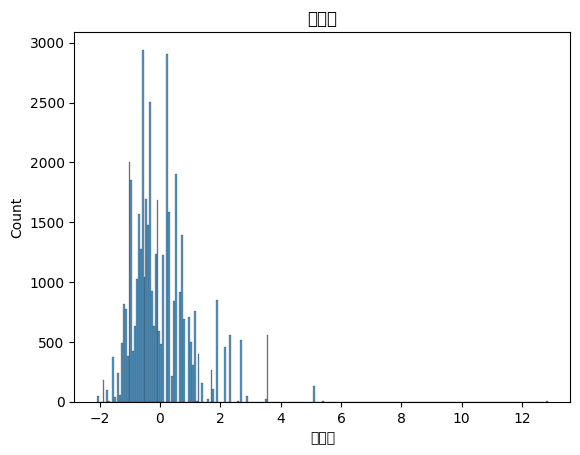

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35079 (\N{CJK UNIFIED IDEOGRAPH-8907}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21213 (\N{CJK UNIFIED IDEOGRAPH-52DD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


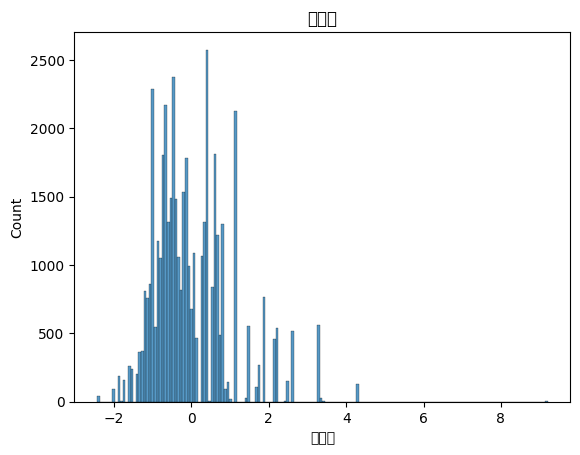

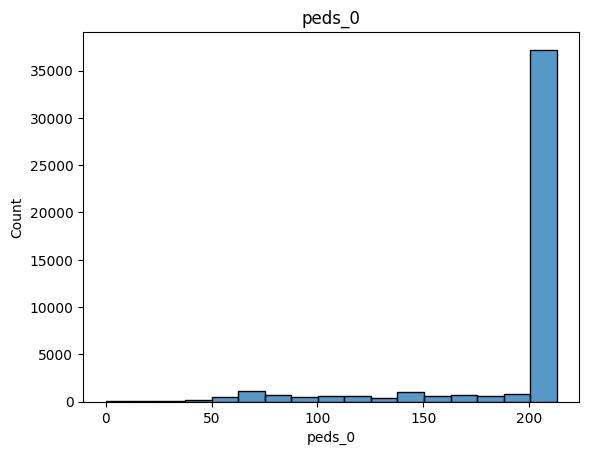

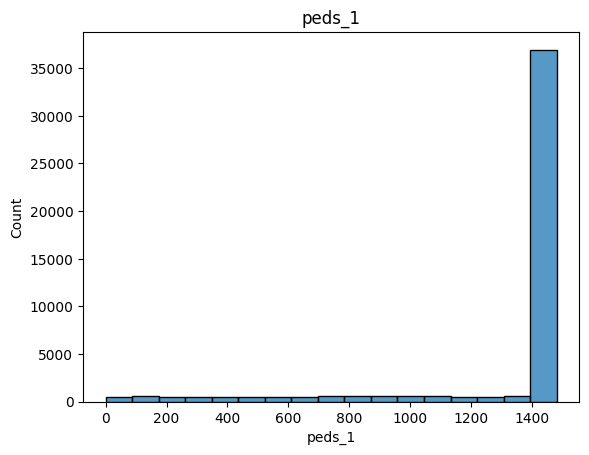

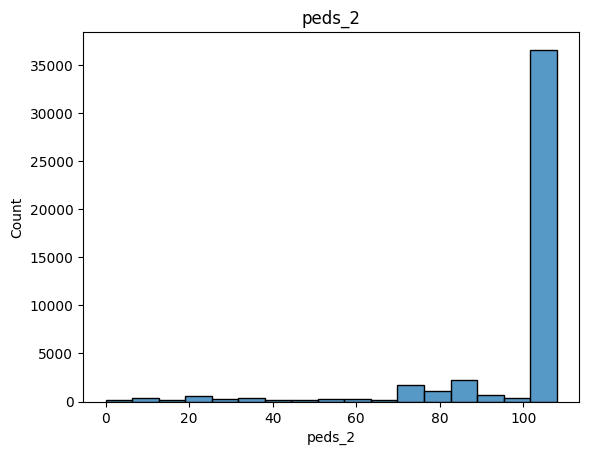

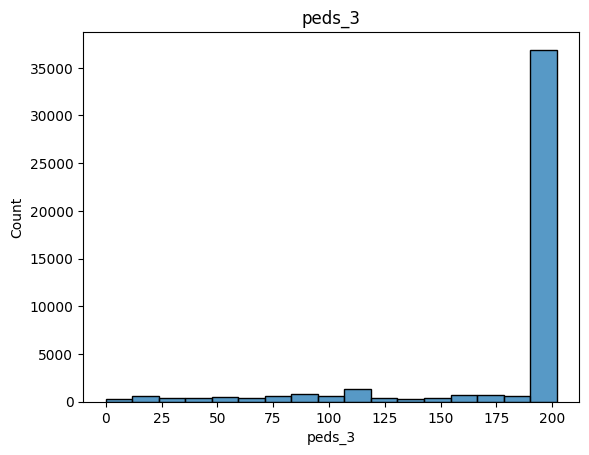

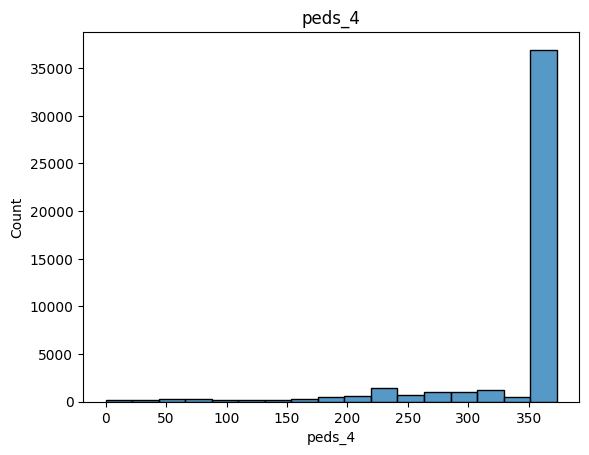

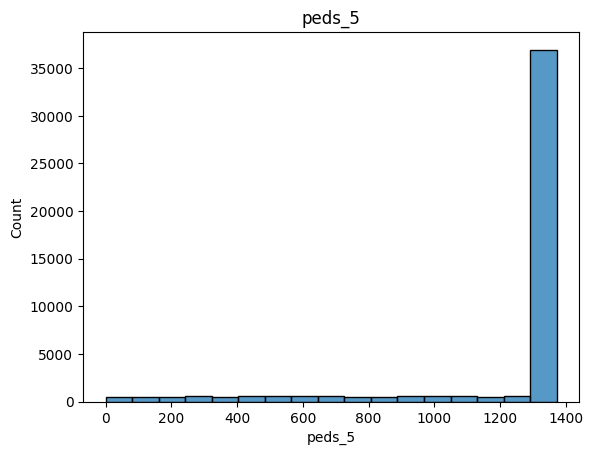

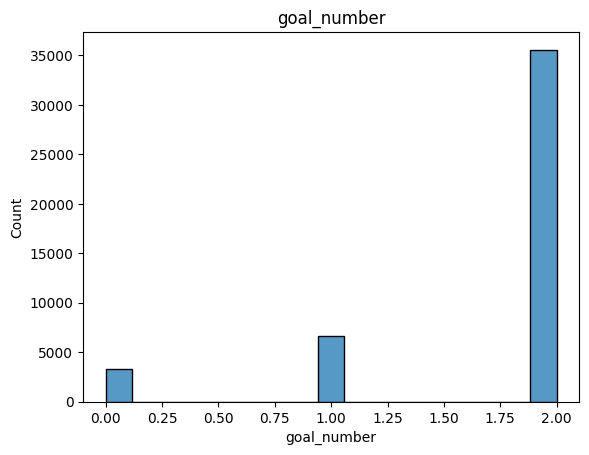

In [17]:
# train_dataの特長量のヒストグラムを表示する
features = train_data.columns
for feature in features:
    plt.figure()
    sns.histplot(train_data[feature])
    # タイトルは日本語でも表示できるようにする
    plt.title(feature)
    plt.show()


In [18]:
# train_dataを7:3でテストデータに分ける
from sklearn.model_selection import train_test_split
# テストデータと学習データ分割
train_total,test_total = train_test_split(train_data, test_size=0.3, random_state=42)

In [19]:
y = train_total['goal_number']
train_total.drop('goal_number', axis=1, inplace=True)

In [20]:
y_test_true = test_total['goal_number']
test_total.drop('goal_number', axis=1, inplace=True)

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(train_total, y, test_size=0.2, random_state=42)

train data length 25526
valid data length 6382
test data length 13675
train data length 25526
valid data length 6382
test data length 13675


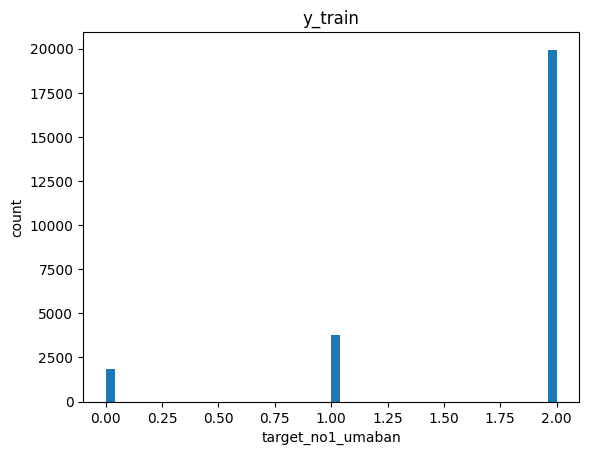

42871    2
34701    2
29495    2
3006     2
30409    2
        ..
10617    1
4999     2
27551    2
34762    2
13201    1
Name: goal_number, Length: 25526, dtype: int64


In [22]:
# 学習データ、検証データ、テストデータの割り振りが完了したので、それぞれのデータ数を表示する
print("train data length {}".format(len(X_train)))
print("valid data length {}".format(len(X_valid)))
print("test data length {}".format(len(test_total)))
# 回答データについても、同様にデータ数を表示する
print("train data length {}".format(len(y_train)))
print("valid data length {}".format(len(y_valid)))
print("test data length {}".format(len(y_test_true)))

# 回答データのヒストグラムを表示する
# 横軸をすべての番号で表示する
f, (ax) = plt.subplots()
ax.hist(y_train, bins=50)
ax.set_title('y_train')
ax.set_xlabel('target_no1_umaban')
ax.set_ylabel('count')

plt.show()

print(y_train)


In [23]:
import lightgbm as lgb
from sklearn.utils.class_weight import compute_sample_weight
dtrain = lgb.Dataset(X_train, label=y_train)  # 学習用
dvalid = lgb.Dataset(X_valid, label=y_valid)  # early_stopping用
# precisionの向上には重みづけが有効
# dtrain = lgb.Dataset(X_train, label=y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
# dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
# https://qiita.com/Dixhom/items/fd78f461d038798a7e2e
# fobj=fobjというハイパラもある？
print(compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
print(np.ones(len(X_valid)).astype('float32'))

[0.42656374 0.42656374 0.42656374 ... 0.42656374 0.42656374 2.2623415 ]
[1. 1. 1. ... 1. 1. 1.]


In [24]:
# feature_names = dtrain.feature_name
# clean_feature_names = [name.replace(' ', '_').replace(':', '_').replace('"', '_').replace("'", '_') for name in feature_names]
# # データセットに新しい特徴量名を設定
# dtrain.feature_name = clean_feature_names
# dvalid.feature_name = clean_feature_names

In [25]:
learning_rate = 0.01
num_leaves = 15
max_depth = 12
min_data_in_leaf = 10
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    # 'metric': 'rmse',
    'metric': 'multi_logloss',
    # 'metric': 'auc', # AUCでもいい
    'num_class': 3, # クラスの数
    
    # "seed":[31],
    # 'random_state': [42],
    # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
    # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
    # 'verbose' : [-1],
    "num_iterations":100, # early stopping で止まるため大きめに設定しておけばよい
    
    # 以下のパラメータを調整対象とする
    "learning_rate": learning_rate, #学習率
    "num_leaves":num_leaves,
    "max_depth":max_depth,
    "min_data_in_leaf":min_data_in_leaf,
    # "bagging_fraction":[0.8],
    # "bagging_freq":[1],
}

In [26]:
#学習
# 以下を参考にearly stoppingを10で設定
# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
# ステップごとの処理結果の保存コールバックで実施するよう仕様変更更
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html

verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
evaluation_results = {} 
import time
starttime = time.time()
# best_params = gcv.best_params_
best_params = params

gbm = lgb.train(best_params,
                dtrain,
                #categorical_feature=categorical_features,
                valid_sets=[dtrain,dvalid],
                valid_names=['train', 'valid'],     
                num_boost_round = 100,
                # feval=acquire_custom_metircs, 
                callbacks=[lgb.early_stopping(stopping_rounds=100, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval),
                           lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
                )

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4131
[LightGBM] [Info] Number of data points in the train set: 25526, number of used features: 38
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.641961
[LightGBM] [Info] Start training from score -1.915013
[LightGBM] [Info] Start training from score -0.246619
Training until validation scores don't improve for 100 rounds


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[100]	train's multi_logloss: 0.52709	valid's multi_logloss: 0.546757


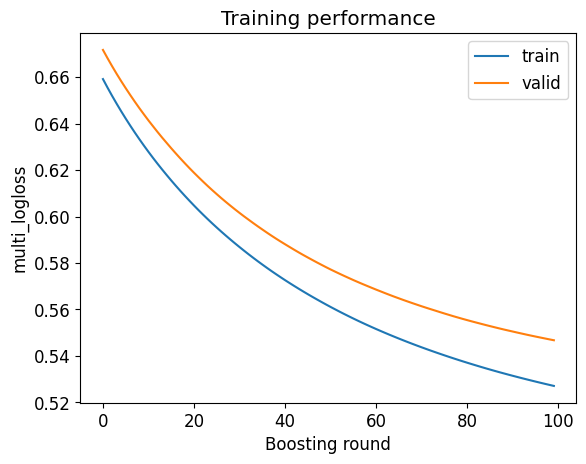

In [27]:
# 学習過程の可視化
plt.rcParams["font.size"] = 12
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('multi_logloss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()

In [28]:
# 検証データを推論
y_pred_train = gbm.predict(X_valid)
y_pred_train = pd.DataFrame(y_pred_train)
print(y_pred_train.head())
print(y_pred_train[0])

          0         1         2
0  0.024583  0.049619  0.925798
1  0.029997  0.093192  0.876811
2  0.024868  0.054439  0.920693
3  0.032892  0.076443  0.890665
4  0.095577  0.242210  0.662214
0       0.024583
1       0.029997
2       0.024868
3       0.032892
4       0.095577
          ...   
6377    0.055785
6378    0.282897
6379    0.042214
6380    0.024583
6381    0.055914
Name: 0, Length: 6382, dtype: float64


In [29]:
y_pred_int = y_pred_train.idxmax(axis=1)
# y_pred_int = np.argmax(y_pred_train.values, axis=1)
# y_pred_int = y_pred_train.astype(int)
y_pred_int

0       2
1       2
2       2
3       2
4       2
       ..
6377    2
6378    2
6379    2
6380    2
6381    2
Length: 6382, dtype: int64

In [30]:
# yvalidのラベルの配列をy_pred_trainから取得して正解のラベルの予測確率値を取得
y_pred_correct = []
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_correct.append(y_probability)

# ラベル無視して最大確率のみを抽出した配列。
y_pred_correct

# ラベルごとの確率値を取得
# 0~10のラベルごとの確率値を取得
y_pred_categorical = [[] for _ in range(19)]
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_categorical[y_val].append(y_probability)

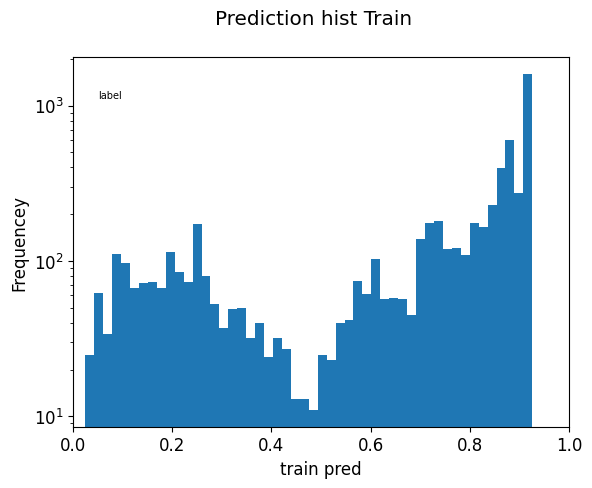

In [31]:
# 正解ラベルの確率値のヒストグラム作成
f, (ax) = plt.subplots()
f.suptitle('Prediction hist Train')

bins = 50

ax.hist(y_pred_correct, bins = bins)

plt.xlabel('train pred')
plt.ylabel('Frequencey')
plt.xlim((0, 1))
plt.yscale('log')
plt.text(0.05, 0.89, 'label',transform = ax.transAxes, fontsize = 7)
plt.show();

# 確率が低い（つまり他のジャンルと分類される）ものが多い。理想は左画はほぼなくて、右に寄ったグラフが作成できること。

In [32]:
# for i, y_pred_category in enumerate(y_pred_categorical):
#     f, (ax) = plt.subplots()
#     f.suptitle('Prediction hist Train')

#     bins = 50

#     ax.hist(y_pred_category, bins = bins)

#     plt.xlabel('train pred')
#     plt.ylabel('Frequencey')
#     plt.xlim((0, 1))
#     plt.yscale('log')
#     plt.text(0.05, 0.9, 'labele is :{}'.format(i),transform = ax.transAxes, fontsize = 14)
#     plt.show();

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39340 (\N{CJK UNIFIED IDEOGRAPH-99AC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22580 (\N{CJK UNIFIED IDEOGRAPH-5834}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35079 (\N{CJK UNIFIED IDEOGRAPH-8907}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21213 (\N{CJK UNIFIED IDEOGRAPH-52DD}) missing from current font.
  fig.c

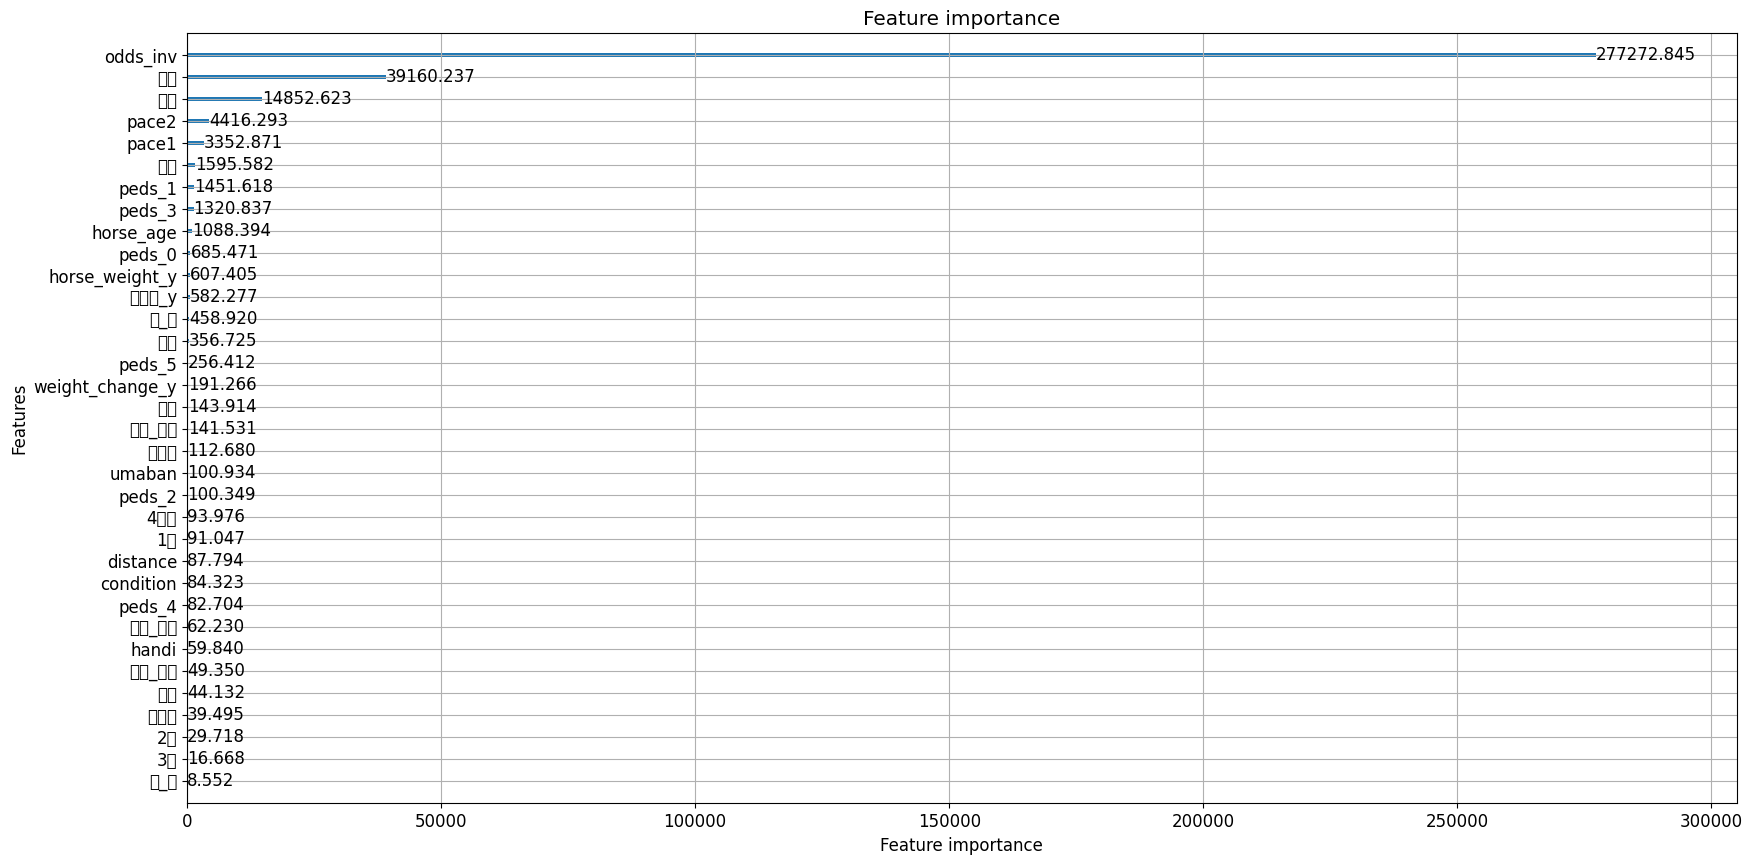

In [33]:
# 4. feature importanceが確認できる
# 特徴点（特徴量）の寄与率を明示化する。特徴点抽出
# 学習後、以下のURLを参考に寄与率を算出させてみる。
# https://qiita.com/ku_a_i/items/74241c84cda8c7327277
lgb.plot_importance(gbm, figsize=(20,10),importance_type='gain')

f1_score=0.7792228141648386


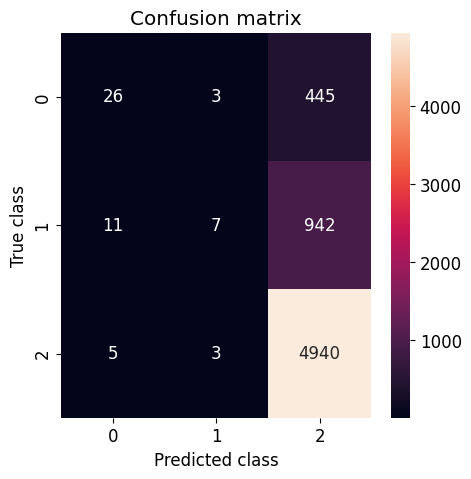

In [34]:
import os
import datetime
from sklearn import metrics
Dicision_threshould = 0.5

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "LightGBM"+ "_" + str(Dicision_threshould)+ '.png'


if not os.path.isdir(path):
   os.mkdir(path)


# スコア(RMSE)算出
# y_pred_int = np.where(y_pred_train > Dicision_threshould, 1, 0)
y_pred_int = y_pred_train.idxmax(axis=1)

f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

label = ["一位","二位か三位","四位以降"]

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()

f1_score=0.7792228141648386


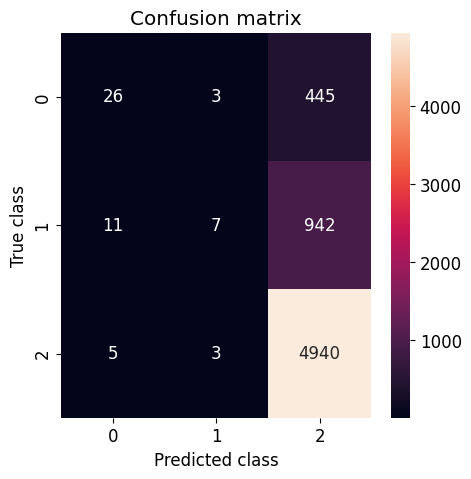

In [35]:
import os
import datetime
from sklearn import metrics

Dicision_threshould = 0.7

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "Ansamble"+ "_" + str(Dicision_threshould)+ '.png'

# y_pred_train_ansamble = (y_pred_train_rf + y_pred_train) / 2.0


# スコア(RMSE)算出

# y_pred_train_ansamble = y_pred_int * 0.8 + y_pred_train_rf * 0.2
# y_pred_int = y_pred_train_ansamble.idmax(axis=1)


f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

plt.rcParams["font.size"] = 12

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()


inference test data and compare with test correct data
              precision    recall  f1-score   support

           0       0.68      0.06      0.11      1048
           1       0.64      0.01      0.02      1950
           2       0.79      1.00      0.88     10677

    accuracy                           0.79     13675
   macro avg       0.70      0.36      0.34     13675
weighted avg       0.76      0.79      0.70     13675



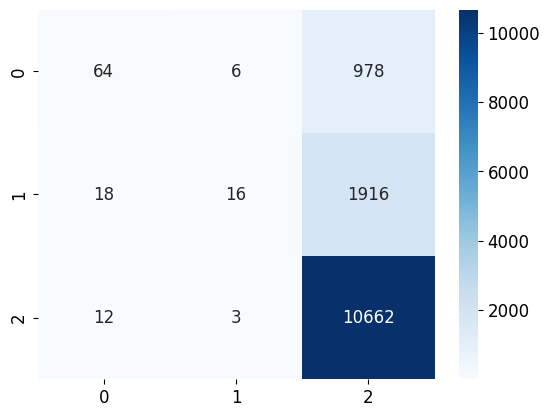

In [36]:
########### inference test data and compare with test correct data ###########
print("inference test data and compare with test correct data")
# ワンホットベクトル化しているのでテストのほうではカラムがないやつもあり数がずれるのでこの引数が必要。
y_pred = gbm.predict(test_total)
y_pred = pd.DataFrame(y_pred)
y_pred_submit = y_pred.idxmax(axis=1)

# テストデータの推論結果と、正解データを比較する
from sklearn.metrics import classification_report
print(classification_report(y_test_true, y_pred_submit))
# confusion matrixを表示する
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_true, y_pred_submit)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.show()

# precisionが正解率。0と1のprecisionが高いと使い物になってくる。なぜなら高い順位の馬を推論できているから

In [37]:
train_data_for_ranking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45583 entries, 0 to 45582
Data columns (total 67 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            45583 non-null  object 
 1   枠番            45583 non-null  int64  
 2   馬番            45583 non-null  int64  
 3   馬名            45583 non-null  object 
 4   性齢            45583 non-null  object 
 5   斤量            45583 non-null  float64
 6   騎手_x          45583 non-null  object 
 7   タイム_x         45171 non-null  object 
 8   着差_x          41837 non-null  object 
 9   単勝            45583 non-null  object 
 10  人気            45400 non-null  float64
 11  馬体重_x         45583 non-null  object 
 12  調教師           45583 non-null  object 
 13  course_len    45583 non-null  int64  
 14  weather       45583 non-null  object 
 15  race_type     45583 non-null  object 
 16  ground_state  45583 non-null  object 
 17  date          45583 non-null  object 
 18  horse_id      45583 non-nu

In [38]:
def odds_feature_engineering(train_data_for_ranking):
    # クエリを使用してオッズの特長量をエンジニアリング
    # 1 オッズを対数変換
    train_data_for_ranking["log_odds"] = np.log1p(train_data_for_ranking["odds"])

    # 2 同一レースidにおけるオッズのmin-max正規化
    train_data_for_ranking["normalized_odds"] = (train_data_for_ranking["odds"] - train_data_for_ranking["odds"].min()) / (train_data_for_ranking["odds"].max() - train_data_for_ranking["odds"].min())
    # 3 zスコア標準化
    train_data_for_ranking["zscore_odds"] = (train_data_for_ranking["odds"] - train_data_for_ranking["odds"].mean()) / train_data_for_ranking["odds"].std()

    # 4オッズの順位
    train_data_for_ranking["odds_rank"] = train_data_for_ranking.groupby('race_id')['odds'].rank(ascending=True, method='min')

    # 5 レースごとのオッズのばらつき
    train_data_for_ranking["odds_std"] = train_data_for_ranking.groupby("race_id")["odds"].transform("std")
    return train_data_for_ranking

train_data_for_ranking = odds_feature_engineering(train_data_for_ranking)


In [39]:
# 各レースごとにオッズをソートして1位、2位、3位のオッズを取得
def get_odds_differences(df):
    odds_diff_1_2 = []
    odds_diff_1_3 = []
    for race_id, group in df.groupby('race_id'):
        sorted_group = group.sort_values('odds')
        if len(sorted_group) >= 3:
            odds_1 = sorted_group.iloc[0]['odds']
            odds_2 = sorted_group.iloc[1]['odds']
            odds_3 = sorted_group.iloc[2]['odds']
            odds_diff_1_2.extend([odds_1 - odds_2] * len(group))
            odds_diff_1_3.extend([odds_1 - odds_3] * len(group))
        else:
            odds_diff_1_2.extend([None] * len(group))
            odds_diff_1_3.extend([None] * len(group))
    return odds_diff_1_2, odds_diff_1_3

# オッズの差分を計算して新しい特徴量として追加
odds_diff_1_2, odds_diff_1_3 = get_odds_differences(train_data_for_ranking)
train_data_for_ranking['odds_diff-1-2'] = odds_diff_1_2
train_data_for_ranking['odds_diff-1-3'] = odds_diff_1_3

# 結果を確認
# print(train_data_for_ranking[['race_id', 'odds', 'odds_diff_1_2', 'odds_diff_1_3']].head())

In [40]:
# ランキング学習での推論
# step1 クエリを作成する
# ランキング学習のためのクエリを作成

# ============データ情報整理================
# X_train: 学習用データ。クエリ必要
# X_valid: 検証データ。クエリ必要
# y_train: 学習用データの答え
# y_valid: 検証データの答え
# test_total: テストデータ。クエリ不要
# y_test_true: テストデータの答え
# ========================================
# ランキング学習用のtrain dataを7:3で分割。この際データがばらばらに混ざってしまうので上から7割を学習データ、残りをテストデータとする
train_ranking = train_data_for_ranking[:int(len(train_data_for_ranking)*0.7)]
test_ranking = train_data_for_ranking[int(len(train_data_for_ranking)*0.7):]
test_ranking_race_id = test_ranking["race_id"]
# train_rankingを7:3で分割。この際データがばらばらに混ざってしまうので上から7割を学習データ、残りをテストデータとする
train_ranking = train_ranking[:int(len(train_ranking)*0.7)]
valid_ranking = train_ranking[int(len(train_ranking)*0.7):]

def create_query(df, name='train'):
    # データの先頭を表示して確認
    # print("DataFrame head:")
    # print(df.head())


    # groupbyを使用してdate, race_name, place, number_of_horses, distanceごとにカウント
    race_place_counts = df.groupby(['race_id']).size().reset_index(name='horse_count')

    # date列を昇順にソート
    # race_place_counts = race_place_counts.sort_values(by='date', ascending=False)

    # 各レースの馬の数をリストに保存
    horse_counts_list = race_place_counts['horse_count'].tolist()

    # 結果の表示
    print("\nResulting list of horse counts per race (sorted by date):")
    print(horse_counts_list)

    # 特徴量データを日付の古い順にソート
    # sorted_df = df.sort_values(by='date', ascending=True)

    # ソートデータの保存
    df.to_csv("sorted_{}_data.csv".format(name), index=False)
    # date, race_name, place, number_of_horses, distanceのユニークな組み合わせを表示して確認
    print("\nUnique combinations of date, race_name, place, number_of_horses, distance:")
    # 上から100データを表示
    print(df[['course_len', 'weather', 'race_type', 'ground_state', 'date']].head(100))
    return horse_counts_list, df

# trainデータのクエリを作成
train_query, sorted_train_data = create_query(train_ranking,"train")
# validデータのクエリを作成
valid_query, sorted_valid_data = create_query(valid_ranking,"valid")





Resulting list of horse counts per race (sorted by date):
[5, 12, 14, 14, 14, 14, 11, 9, 10, 13, 16, 12, 7, 14, 16, 14, 8, 16, 9, 10, 12, 8, 11, 14, 10, 14, 16, 14, 14, 12, 9, 14, 9, 14, 14, 12, 14, 12, 14, 15, 12, 14, 10, 14, 12, 10, 14, 10, 10, 14, 16, 14, 9, 16, 11, 13, 14, 14, 12, 14, 14, 12, 16, 14, 8, 14, 13, 10, 14, 16, 14, 16, 7, 14, 12, 14, 7, 16, 12, 11, 13, 12, 14, 16, 7, 12, 14, 14, 9, 13, 14, 7, 12, 12, 16, 12, 10, 14, 16, 14, 8, 14, 16, 12, 13, 12, 14, 9, 9, 12, 14, 14, 9, 12, 13, 10, 14, 16, 12, 14, 7, 9, 12, 14, 12, 14, 14, 12, 14, 14, 14, 10, 8, 14, 12, 14, 12, 16, 12, 14, 15, 14, 16, 14, 13, 14, 16, 14, 12, 12, 14, 16, 13, 14, 12, 16, 12, 12, 14, 16, 14, 16, 14, 14, 10, 15, 14, 14, 16, 14, 12, 16, 11, 14, 13, 11, 15, 16, 16, 14, 16, 14, 10, 14, 14, 14, 10, 13, 9, 14, 16, 12, 16, 14, 12, 16, 7, 8, 16, 12, 8, 12, 12, 14, 14, 16, 12, 14, 7, 16, 14, 14, 10, 11, 16, 14, 9, 12, 16, 11, 7, 16, 7, 12, 11, 9, 16, 8, 16, 11, 12, 16, 5, 11, 10, 10, 9, 13, 14, 9, 5, 12, 16, 13, 

In [41]:
# クエリの数の合計を確認
print("Number of queries in train data: {}".format(sum(train_query)))
print("Number of queries in valid data: {}".format(sum(valid_query)))
print("Total number of queries: {}".format(len(train_query) + len(valid_query)))
print("Number of rows in train data: {}".format(len(sorted_train_data)))
print("Number of rows in valid data: {}".format(len(sorted_valid_data)))
print("Total number of rows: {}".format(len(sorted_train_data) + len(sorted_valid_data)))


Number of queries in train data: 22335
Number of queries in valid data: 6701
Total number of queries: 2099
Number of rows in train data: 22335
Number of rows in valid data: 6701
Total number of rows: 29036


In [42]:
# クエリを取得したので前処理をかける
X_sorted_train_data = preprocess(sorted_train_data,is_ranking=True)
X_sorted_valid_data = preprocess(sorted_valid_data,is_ranking=True)
test_ranking = preprocess(test_ranking,is_ranking=True)

Index(['着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手_x', 'タイム_x', '着差_x', '単勝', '人気',
       '馬体重_x', '調教師', 'course_len', 'weather', 'race_type', 'ground_state',
       'date', 'horse_id', 'jockey_id', 'race_id', '日付', '開催', '天 気', 'R',
       'レース名', '映 像', '頭 数', '枠 番', '馬 番', 'オ ッ ズ', '人 気', '着 順', '騎手_y',
       '斤 量', '距離', '馬 場', '馬場 指数', 'タイム_y', '着差_y', 'ﾀｲﾑ 指数', '通過', 'ペース',
       '上り', '馬体重_y', '厩舎 ｺﾒﾝﾄ', '備考', '勝ち馬 (2着馬)', '賞金', 'peds_0', 'peds_1',
       'peds_2', 'peds_3', 'peds_4', 'peds_5', '年度', '1着', '2着', '3着', '4着〜',
       '騎乗 回数', '重賞 出走', '重賞 勝利', '勝率', '連対率', '複勝率', 'odds', 'log_odds',
       'normalized_odds', 'zscore_odds', 'odds_rank', 'odds_std',
       'odds_diff-1-2', 'odds_diff-1-3', 'goal_number', 'goal_number_replace',
       'horse_sex', 'horse_age', 'horse_weight', 'weight_change', 'handi',
       'distance', 'condition', 'umaban', 'odds_inv', 'pace1', 'pace2',
       'horse_weight_y', 'weight_change_y'],
      dtype='object')
<class 'pandas.core.frame.Dat

/tmp/ipykernel_20174/4287171729.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_20174/4287171729.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_20174/4287171729.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Index(['着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手_x', 'タイム_x', '着差_x', '単勝', '人気',
       '馬体重_x', '調教師', 'course_len', 'weather', 'race_type', 'ground_state',
       'date', 'horse_id', 'jockey_id', 'race_id', '日付', '開催', '天 気', 'R',
       'レース名', '映 像', '頭 数', '枠 番', '馬 番', 'オ ッ ズ', '人 気', '着 順', '騎手_y',
       '斤 量', '距離', '馬 場', '馬場 指数', 'タイム_y', '着差_y', 'ﾀｲﾑ 指数', '通過', 'ペース',
       '上り', '馬体重_y', '厩舎 ｺﾒﾝﾄ', '備考', '勝ち馬 (2着馬)', '賞金', 'peds_0', 'peds_1',
       'peds_2', 'peds_3', 'peds_4', 'peds_5', '年度', '1着', '2着', '3着', '4着〜',
       '騎乗 回数', '重賞 出走', '重賞 勝利', '勝率', '連対率', '複勝率', 'odds', 'log_odds',
       'normalized_odds', 'zscore_odds', 'odds_rank', 'odds_std',
       'odds_diff-1-2', 'odds_diff-1-3', 'goal_number', 'goal_number_replace',
       'horse_sex', 'horse_age', 'horse_weight', 'weight_change', 'handi',
       'distance', 'condition', 'umaban', 'odds_inv', 'pace1', 'pace2',
       'horse_weight_y', 'weight_change_y'],
      dtype='object')
<class 'pandas.core.frame.Dat

/tmp/ipykernel_20174/4287171729.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['odds'] = train_data['単勝'].apply(lambda x: float(x))
/tmp/ipykernel_20174/4287171729.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['odds_inv'] = train_data['odds'].apply(lambda x: 1 / x)
/tmp/ipykernel_20174/4287171729.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [43]:
# うまく目的変数の変換ができないので、現状のデータを見てみる
# X_sorted_train_data.to_csv("X_sorted_train_data.csv", index=False)

In [44]:
# X_sorted_train_dataにgoal_number_replaceを追加してcsvに保存する
# X_sorted_train_data.to_csv("X_sorted_train_data_add_goal_number.csv", index=False)

In [45]:
# 1. 目的変数goal_number_replaceを確保
# 2. 実際のgoal_numberを確保
# 3. goal_number_replaceを削除
# 4. goal_numberを削除
# 1========================================================
y_train_ranking = X_sorted_train_data['goal_number_replace']
y_valid_ranking = X_sorted_valid_data['goal_number_replace']
y_test_true_ranking = test_ranking['goal_number_replace']
# 2========================================================
y_train_ranking_goal = X_sorted_train_data['goal_number']
y_valid_ranking_goal = X_sorted_valid_data['goal_number']
y_test_true_ranking_goal = test_ranking['goal_number']
# 3========================================================
X_sorted_train_data = X_sorted_train_data.drop('goal_number', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('goal_number', axis=1)
test_ranking = test_ranking.drop('goal_number', axis=1)
# 4========================================================
X_sorted_train_data = X_sorted_train_data.drop('goal_number_replace', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('goal_number_replace', axis=1)
test_ranking = test_ranking.drop('goal_number_replace', axis=1)


In [46]:
# 学習データ
X_sorted_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22335 entries, 0 to 22334
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         22335 non-null  int64  
 1   condition        22335 non-null  int64  
 2   umaban           22335 non-null  int64  
 3   horse_age        22335 non-null  int64  
 4   horse_sex        22335 non-null  int64  
 5   handi            22335 non-null  int64  
 6   odds_inv         22335 non-null  float64
 7   天 気              22335 non-null  int64  
 8   頭 数              22332 non-null  float64
 9   枠番               22335 non-null  int64  
 10  馬番               22335 non-null  int64  
 11  人気               22255 non-null  float64
 12  斤量               22335 non-null  float64
 13  距離               22335 non-null  int64  
 14  馬 場              22335 non-null  int64  
 15  タイム_y            21872 non-null  float64
 16  pace1            22291 non-null  float64
 17  pace2       

In [47]:
# クエリの合計とデータの合計が一致しているか確認
print("Number of queries in train data: {}".format(sum(train_query)))
print("Number of queries in valid data: {}".format(sum(valid_query)))
# y_train_rankingの数とX_sorted_train_dataの数が一致しているか確認
print("y_train_ranking length {}".format(len(y_train_ranking)))
print("Number of rows in train data: {}".format(len(X_sorted_train_data)))
print("Number of rows in valid data: {}".format(len(X_sorted_valid_data)))
print("Total number of rows: {}".format(len(X_sorted_train_data) + len(X_sorted_valid_data)))

Number of queries in train data: 22335
Number of queries in valid data: 6701
y_train_ranking length 22335
Number of rows in train data: 22335
Number of rows in valid data: 6701
Total number of rows: 29036


In [48]:
# スクレイピングするごとにカラム名が変化してくので、カラム名のスペースを削除する処理を学習前に追加
# X_sorted_train_data.columnsの日本語文字列の半角、全角スペースを削除する
X_sorted_train_data.columns = X_sorted_train_data.columns.str.replace(' ', '')
X_sorted_train_data.columns = X_sorted_train_data.columns.str.replace('　', '')

# X_sorted_valid_data.columnsの日本語文字列の半角、全角スペースを削除する
X_sorted_valid_data.columns = X_sorted_valid_data.columns.str.replace(' ', '')
X_sorted_valid_data.columns = X_sorted_valid_data.columns.str.replace('　', '')

# test_ranking.columnsの日本語文字列の半角、全角スペースを削除する
test_ranking.columns = test_ranking.columns.str.replace(' ', '')
test_ranking.columns = test_ranking.columns.str.replace('　', '')



In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
from sklearn.metrics import ndcg_score

# データの準備
# X_sorted_train_data, y_train_ranking, train_query
# X_sorted_valid_data, y_valid_ranking, valid_query

# ランキング学習
model = lgb.LGBMRanker(
    random_state=42,
    objective='lambdarank',
    metric='ndcg',
    n_estimators=500,              # 決定木の個数(default:100) 5000のほうが10000より高い
    learning_rate=0.1,            # 学習率(default:0.1)
    num_leaves=5,                 # 決定木にある分岐の個数(default:31)
    max_depth=3,                  # 決定木の深さの最大値(default:-1)
    min_child_samples=5,         # 決定木のノードに含まれる最小サンプル数(default:20)
    # feature_fraction=0.8,
    # bagging_fraction=0.8,
    # bagging_freq=10,
    # lambda_l1=0.1,
    # lambda_l2=0.1,
    # min_split_gain=0.1,
    # min_child_weight=0.1
    rambdalank_truncation_level=10,
    max_position=3, # 3位までの順位を予測する
)

# モデルの学習
model.fit(
    X_sorted_train_data,
    y_train_ranking,
    group=train_query,
    eval_set=[(X_sorted_valid_data, y_valid_ranking)],
    eval_group=[valid_query],
    eval_at=[1, 2, 3],
    eval_metric='ndcg',
)

[LightGBM] [Warning] Unknown parameter: rambdalank_truncation_level
[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Warning] Unknown parameter: rambdalank_truncation_level
[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5142
[LightGBM] [Info] Number of data points in the train set: 22335, number of used features: 43
[LightGBM] [Warning] Unknown parameter: rambdalank_truncation_level
[LightGBM] [Warning] Unknown parameter: max_position


LGBMRanker(learning_rate=0.01, max_depth=3, max_position=3, metric='ndcg',
           min_child_samples=5, n_estimators=500, num_leaves=5,
           objective='lambdarank', rambdalank_truncation_level=10,
           random_state=42)

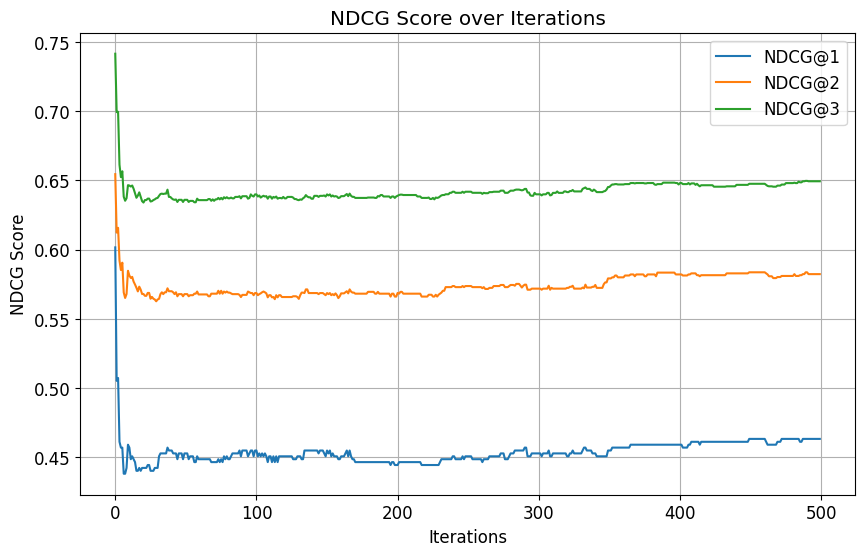

Best NDCG@1: 0.4633 in iteration: 0
Best NDCG@2: 0.5824 in iteration: 0
Best NDCG@3: 0.6494 in iteration: 0


In [50]:
# トレーニング結果の取得
evals_result = model.evals_result_

# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(evals_result['valid_0']['ndcg@1'], label='NDCG@1')
plt.plot(evals_result['valid_0']['ndcg@2'], label='NDCG@2')
plt.plot(evals_result['valid_0']['ndcg@3'], label='NDCG@3')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()
# model.best_iteration_のNDCGを数値で出力
print("Best NDCG@1: {:.4f} in iteration: {}".format(evals_result['valid_0']['ndcg@1'][model.best_iteration_ - 1], model.best_iteration_))
print("Best NDCG@2: {:.4f} in iteration: {}".format(evals_result['valid_0']['ndcg@2'][model.best_iteration_ - 1], model.best_iteration_))
print("Best NDCG@3: {:.4f} in iteration: {}".format(evals_result['valid_0']['ndcg@3'][model.best_iteration_ - 1], model.best_iteration_))

In [ ]:
# アンサンブル候補①LightGBM(RankNet)
# 学習データ： X_sorted_train_data, y_train_ranking
# 学習データのクエリ： train_query
# 検証データ： X_sorted_valid_data, y_valid_ranking
# 検証データのクエリ： valid_query
# テストデータ： test_ranking, y_test_true_ranking

# LightGBMデータセット
train_data = lgb.Dataset(X_sorted_train_data, label=y_train_ranking, group=train_query)
valid_data = lgb.Dataset(X_sorted_valid_data, label=y_valid_ranking, group=valid_query)
# パラメータの設定
params = {
    'objective': 'rank_xendcg',
    'metric': 'ndcg',
    'ndcg_at': [1, 2, 3],
    'n_estimators':500,              # 決定木の個数(default:100) 5000のほうが10000より高い
    'learning_rate':0.1,            # 学習率(default:0.1)
    'num_leaves':5,                 # 決定木にある分岐の個数(default:31)
    'max_depth':5,                  # 決定木の深さの最大値(default:-1)
    "max_position":3, # 3位までの順位を予測する
    "min_data_in_leaf":5,         # 決定木のノードに含まれる最小サンプル数(default:20)
}

evaluation_results = {}
# モデルの学習
ranknet_model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    callbacks=[lgb.record_evaluation(evaluation_results)],
)


[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5142
[LightGBM] [Info] Number of data points in the train set: 22335, number of used features: 43
[LightGBM] [Warning] Unknown parameter: max_position


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


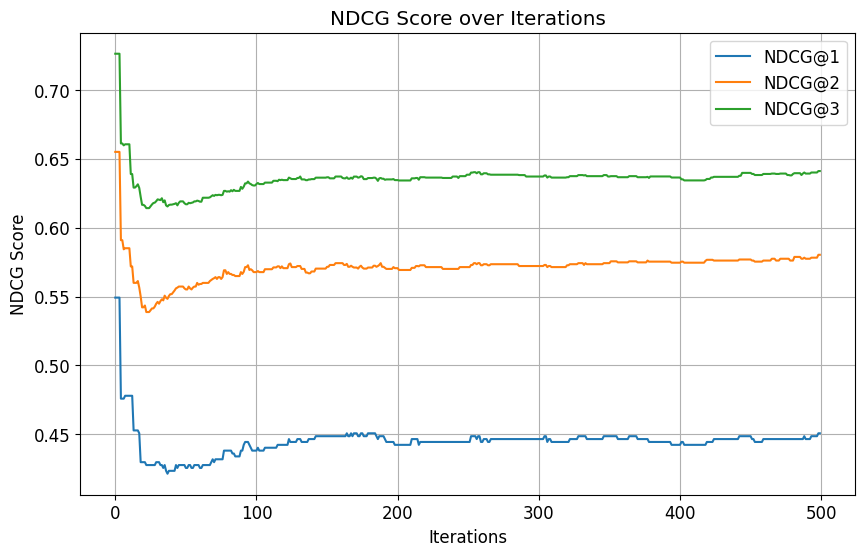

Best NDCG@1: 0.4507 in iteration: 0
Best NDCG@2: 0.5804 in iteration: 0
Best NDCG@3: 0.6412 in iteration: 0


In [52]:

# 学習結果の可視化をndcgで行う
# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(evaluation_results['valid_0']['ndcg@1'], label='NDCG@1')
plt.plot(evaluation_results['valid_0']['ndcg@2'], label='NDCG@2')
plt.plot(evaluation_results['valid_0']['ndcg@3'], label='NDCG@3')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()
# model.best_iteration_のNDCGを数値で出力
print("Best NDCG@1: {:.4f} in iteration: {}".format(ranknet_model.best_score['valid_0']['ndcg@1'], ranknet_model.best_iteration))
# 2も出力
print("Best NDCG@2: {:.4f} in iteration: {}".format(ranknet_model.best_score['valid_0']['ndcg@2'], ranknet_model.best_iteration))
# 3も出力
print("Best NDCG@3: {:.4f} in iteration: {}".format(ranknet_model.best_score['valid_0']['ndcg@3'], ranknet_model.best_iteration))


[23:01:08] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "max_position", "min_child_samples" } are not used.

[0]	validation_0-ndcg:0.67882


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-ndcg:0.81822
[200]	validation_0-ndcg:0.85951
[300]	validation_0-ndcg:0.88070
[400]	validation_0-ndcg:0.89268
[499]	validation_0-ndcg:0.90775


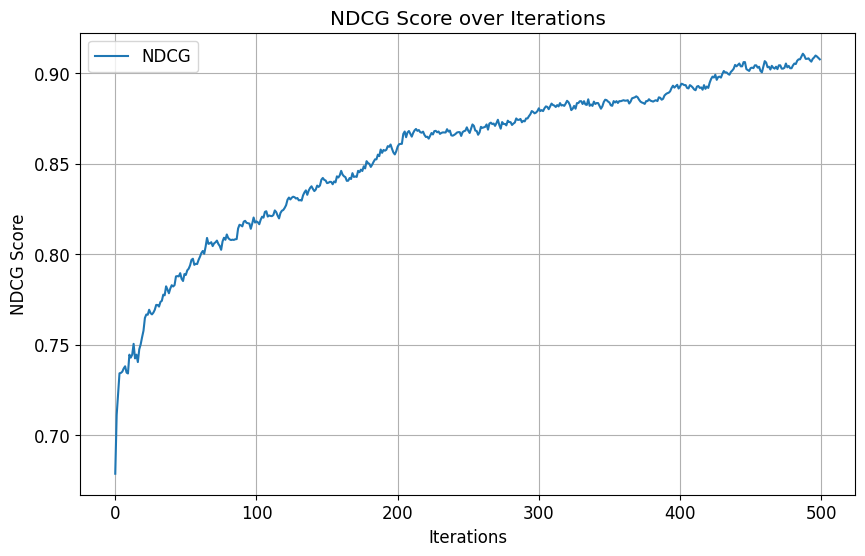

Best NDCG: 0.9108 in iteration: 487


In [ ]:
# アンサンブル候補②XGBoost(Pairwise)
from xgboost import XGBRanker
# モデルの定義
pairwise_model = XGBRanker(
    objective='rank:pairwise',
    eval_metric='ndcg',
    n_estimators=1000,              # 決定木の個数(default:100) 5000のほうが10000より高い
    learning_rate=0.1,            # 学習率(default:0.1)
    max_depth=10,                    # 決定木の深さの最大値(default:6)
    subsample=0.8,                  # データのサンプリング比率(default:1)
    colsample_bytree=0.8,           # 列のサンプリング比率(default:1)
    min_child_weight=0.5,           # 葉の重みの最小値(default:1)
    reg_lambda=1.0,                 # L2正則化の強さ(default:1)
    gamma=0.1,                      # 葉の追加分岐を行うかの閾値(default:0)
    n_jobs=-1,                      # 並列処理の数(default:1)
    random_state=42,                # 乱数のシード値(default:0)
    max_position=3, # 3位までの順位を予測する
    min_child_samples=5,         # 決定木のノードに含まれる最小サンプル数(default:20)
)
# モデルの学習
pairwise_model.fit(
    X_sorted_train_data,
    y_train_ranking,
    group=train_query,
    eval_set=[(X_sorted_valid_data, y_valid_ranking)],
    eval_group=[valid_query],
    verbose=100,
    early_stopping_rounds=200,
)

# 学習結果の可視化をndcgで行う
# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(pairwise_model.evals_result()['validation_0']['ndcg'], label='NDCG')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()
# model.best_iteration_のNDCGを数値で出力
print("Best NDCG: {:.4f} in iteration: {}".format(pairwise_model.best_score, pairwise_model.best_iteration))

[LightGBM] [Warning] Unknown parameter: rambdalank_truncation_level
[LightGBM] [Warning] Unknown parameter: max_position


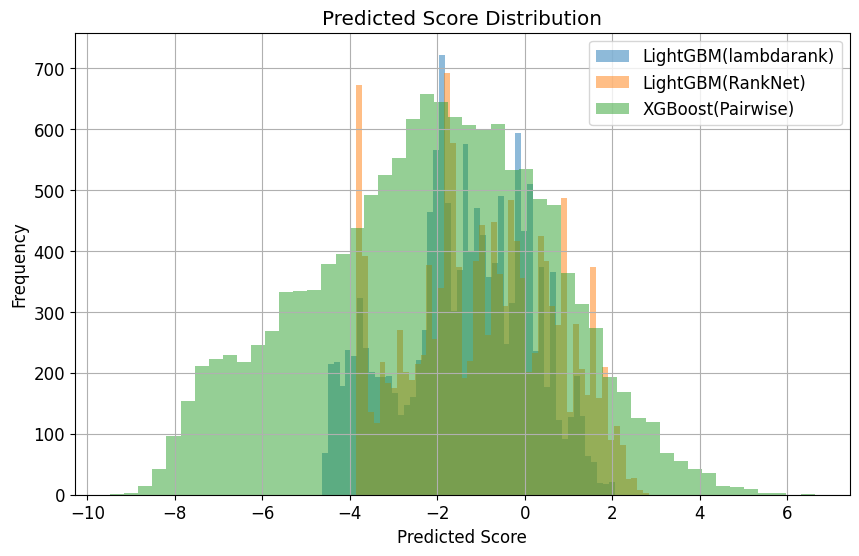

In [54]:
#　テストデータで推論
# LighGBM(lambdarank)の推論
prediction_test_ranking = model.predict(test_ranking, num_iteration=model.best_iteration_)
# 同じレースidのうちスコアの大きい順に1位から予測順位を計算する


# LightGBM(RankNet)の推論
prediction_test_ranking_ranknet = ranknet_model.predict(test_ranking)
# XGBoost(Pairwise)の推論
prediction_test_ranking_pairwise = pairwise_model.predict(test_ranking)

df_prediction_test_ranking = pd.DataFrame({
    "馬番号": test_ranking["umaban"],
    "予測スコア(lambdarank)": prediction_test_ranking,
    "予測スコア(RankNet)": prediction_test_ranking_ranknet,
    "予測スコア(Pairwise)": prediction_test_ranking_pairwise,
    "着順関連度": y_test_true_ranking,
    "着順": y_test_true_ranking_goal,
    "race_id": test_ranking_race_id
})


# 同じレースidのうちスコアの大きい順に1位から予測順位を計算する
df_prediction_test_ranking["予測順位(lambdarank)"] = df_prediction_test_ranking.groupby("race_id")["予測スコア(lambdarank)"].rank(ascending=False, method='first')
df_prediction_test_ranking["予測順位(RankNet)"] = df_prediction_test_ranking.groupby("race_id")["予測スコア(RankNet)"].rank(ascending=False, method='first')
df_prediction_test_ranking["予測順位(Pairwise)"] = df_prediction_test_ranking.groupby("race_id")["予測スコア(Pairwise)"].rank(ascending=False, method='first')

# それぞれの予測順位はfloat型なのでint型に変換
df_prediction_test_ranking["予測順位(lambdarank)"] = df_prediction_test_ranking["予測順位(lambdarank)"].astype(int)
df_prediction_test_ranking["予測順位(RankNet)"] = df_prediction_test_ranking["予測順位(RankNet)"].astype(int)
df_prediction_test_ranking["予測順位(Pairwise)"] = df_prediction_test_ranking["予測順位(Pairwise)"].astype(int)

# print(df_prediction_test_ranking)
# pandasをcsvに保存
# train_path_result = train_path + "inference_result/"
# if not os.path.isdir(train_path_result):
#     os.mkdir(train_path_result)
# df_prediction_test_ranking.to_csv(train_path_result + "prediction_test_ranking.csv", index=False)

# 予測スコアの分布を可視化
plt.figure(figsize=(10, 6))
plt.hist(prediction_test_ranking, bins=50, alpha=0.5, label='LightGBM(lambdarank)')
plt.hist(prediction_test_ranking_ranknet, bins=50, alpha=0.5, label='LightGBM(RankNet)')
plt.hist(prediction_test_ranking_pairwise, bins=50, alpha=0.5, label='XGBoost(Pairwise)')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.title('Predicted Score Distribution')
plt.legend()
plt.grid(True)
plt.show()



LightGBM(lambdarank)の評価
True Positive: 394
False Positive: 628
False Negative: 631
True Negative: 12022
Precision: 0.3855
Recall: 0.3844
F1 Score: 0.3850


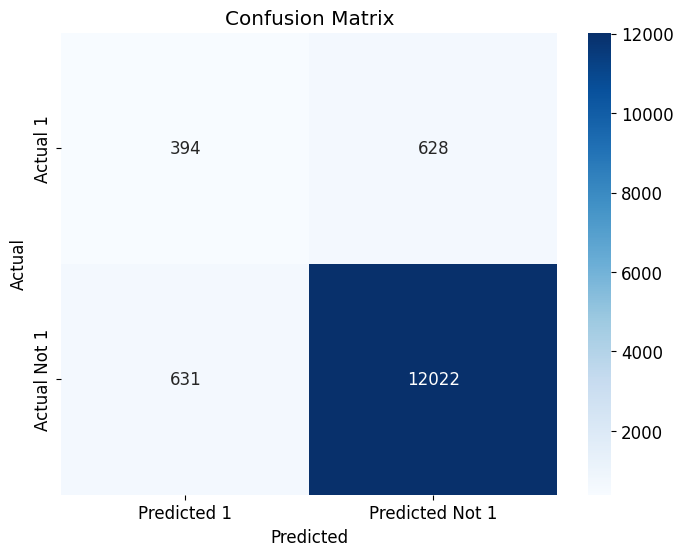

LightGBM(RankNet)の評価
True Positive: 407
False Positive: 615
False Negative: 618
True Negative: 12035
Precision: 0.3982
Recall: 0.3971
F1 Score: 0.3977


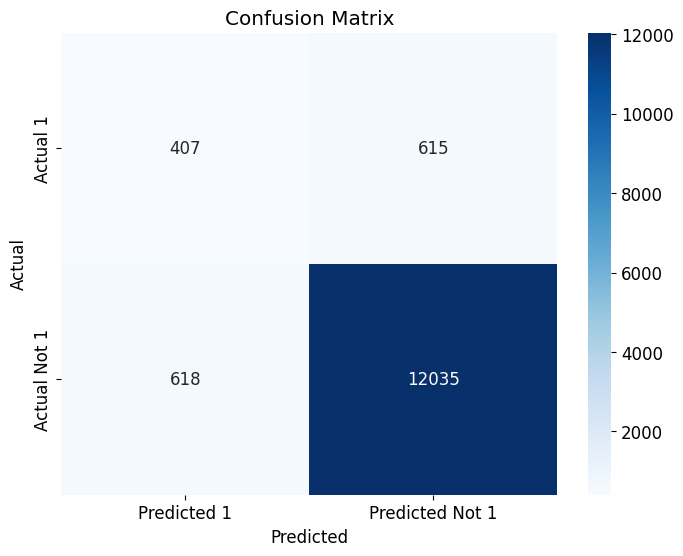

XGBoost(Pairwise)の評価
True Positive: 388
False Positive: 634
False Negative: 637
True Negative: 12016
Precision: 0.3796
Recall: 0.3785
F1 Score: 0.3791


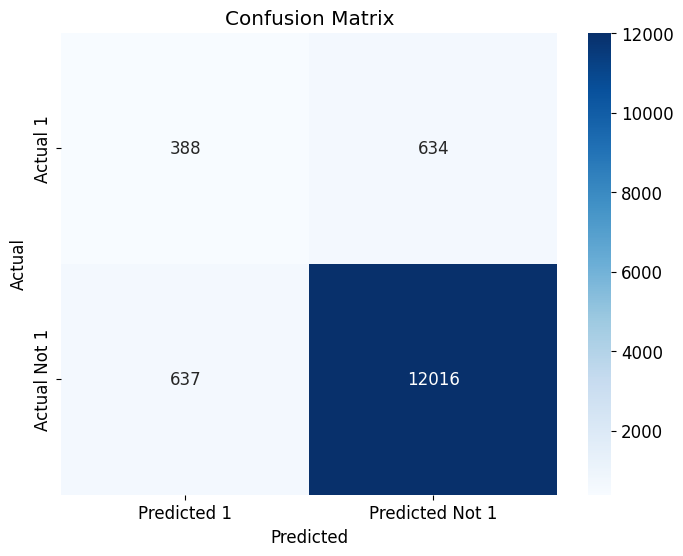

In [55]:
# 予測結果の評価
def rank_evaluation(modelname='予測順位(lambdarank)'):


    # 1位予想で1位だった数
    true_positive = df_prediction_test_ranking[
        (df_prediction_test_ranking[modelname] == 1) & 
        (df_prediction_test_ranking['着順'] == 1)
    ].shape[0]

    # 1位予想で1位じゃなかった数
    false_positive = df_prediction_test_ranking[
        (df_prediction_test_ranking[modelname] == 1) & 
        (df_prediction_test_ranking['着順'] != 1)
    ].shape[0]

    # 1位じゃない予想で1位だった数
    false_negative = df_prediction_test_ranking[
        (df_prediction_test_ranking[modelname] != 1) & 
        (df_prediction_test_ranking['着順'] == 1)
    ].shape[0]

    # 1位じゃない予想で1位じゃなかった数
    true_negative = df_prediction_test_ranking[
        (df_prediction_test_ranking[modelname] != 1) & 
        (df_prediction_test_ranking['着順'] != 1)
    ].shape[0]

    print(f'True Positive: {true_positive}')
    print(f'False Positive: {false_positive}')
    print(f'False Negative: {false_negative}')
    print(f'True Negative: {true_negative}')
    # presicion, recall, f1 scoreの計算
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1 = 2 * precision * recall / (precision + recall)
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Confusion Matrixの作成
    confusion_matrix = np.array([[true_positive, false_positive],
                                [false_negative, true_negative]])

    # Confusion Matrixの可視化
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 1', 'Predicted Not 1'], yticklabels=['Actual 1', 'Actual Not 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
print("LightGBM(lambdarank)の評価")
rank_evaluation('予測順位(lambdarank)')
print("LightGBM(RankNet)の評価")
rank_evaluation('予測順位(RankNet)')
print("XGBoost(Pairwise)の評価")
rank_evaluation('予測順位(Pairwise)')

In [56]:
# 特徴重要度の可視化
df_importance = pd.DataFrame({"columns": X_sorted_train_data.columns, "importance": model.feature_importances_})
df_importance.sort_values("importance", ascending=False, inplace=True)
print(df_importance)

            columns  importance
21               賞金         529
6          odds_inv         444
17            pace2         234
16            pace1         131
38         log_odds         127
15            タイム_y         120
13               距離          67
8                頭数          54
40      zscore_odds          44
1         condition          31
33           peds_1          26
36           peds_4          25
19   horse_weight_y          22
18               上り          20
32           peds_0          16
37           peds_5          13
3         horse_age          13
35           peds_3          12
34           peds_2          12
20  weight_change_y          11
11               人気           7
25              4着〜           6
28             重賞勝利           6
42         odds_std           6
7                天気           5
5             handi           5
0          distance           4
2            umaban           2
22               1着           2
29               勝率           2
14      

In [57]:
# オッズの差分を計算して新しい特徴量として追加
def add_odds_differences_for_inference(df):
    sorted_df = df.sort_values('odds')
    if len(sorted_df) >= 3:
        odds_1 = sorted_df.iloc[0]['odds']
        odds_2 = sorted_df.iloc[1]['odds']
        odds_3 = sorted_df.iloc[2]['odds']
        df['odds_diff-1-2'] = odds_1 - odds_2
        df['odds_diff-1-3'] = odds_1 - odds_3
    else:
        df['odds_diff-1-2'] = None
        df['odds_diff-1-3'] = None
    return df


In [58]:
from pathlib import Path
import pandas as pd
import tqdm

# csvデータを1つずつ読み出し推論
p = Path(inference_data_path)
files = list(p.glob("*inference*.csv"))
count = 0
for file in tqdm.tqdm(files):
    # 読み込んだファイル名を出力
    # print("=======予測ファイル名======== {}".format(file))
    print("=======予測ファイル名========\n {}".format(file))
    inference_data = pd.read_csv(file, encoding='utf-8')
    # データの確認
    # print(inference_data.info())

    # Unnamed: 0,class_list_in_raceを削除
    # inference_data = inference_data.drop(['Unnamed: 0',"class_list_in_race","date"], axis=1)
    # inference_data.info()

    #　=================real dataで推論=============================
    inference_data_answer = inference_data["goal_number"]
    inference_data = inference_data.drop("goal_number", axis=1)

    # 学習データとカラム名を統一する
    # 枠 番は枠番に変換する
    inference_data = inference_data.rename(columns={'枠 番':'枠番'})
    # 馬 番は馬番に変換する
    inference_data = inference_data.rename(columns={'馬 番':'馬番'})
    # 人 気は人気に変換する
    inference_data = inference_data.rename(columns={'人 気':'人気'})
    # 斤 量は斤量に変換する
    inference_data = inference_data.rename(columns={'斤 量':'斤量'})
    # タイムはタイム_yに変換する
    inference_data = inference_data.rename(columns={'タイム':'タイム_y'})
    # 天 気は天気に変換する
    inference_data = inference_data.rename(columns={'天 気':'天気'})
    # 頭 数は頭数に変換する
    inference_data = inference_data.rename(columns={'頭 数':'頭数'})
    # オ ッ ズ はオッズに変換する
    inference_data = inference_data.rename(columns={'オ ッ ズ':'オッズ'})
    # 馬 場は馬場に変換する
    inference_data = inference_data.rename(columns={'馬 場':'馬場'})
    # 騎乗 回数は騎乗回数に変換する
    inference_data = inference_data.rename(columns={'騎乗 回数':'騎乗回数'})
    # 重賞 出走は重賞出走に変換する
    inference_data = inference_data.rename(columns={'重賞 出走':'重賞出走'})
    # 重賞 勝利は重賞勝利に変換する
    inference_data = inference_data.rename(columns={'重賞 勝利':'重賞勝利'})

    # 学習データとの共通処理
    # タイム_yは1:34.0のような形式なので、秒に変換する
    # nanの場合は100に変換する
    # 'タイム_y'列の値を文字列に変換し、NaN値を無視して処理を行う
    inference_data['タイム_y'] = inference_data['タイム_y'].astype(str).apply(
        lambda x: int(x.split(':')[0]) * 60 + float(x.split(':')[1]) if ':' in x else np.nan
    )

    # 'ペース'列の値を文字列に変換し、NaN値を無視して処理を行う
    inference_data['pace1'] = inference_data['ペース'].astype(str).apply(
        lambda x: float(x.split('-')[0]) if '-' in x else np.nan
    )
    inference_data['pace2'] = inference_data['ペース'].astype(str).apply(
        lambda x: float(x.split('-')[1]) if '-' in x else np.nan
    )

    # 馬体重_yは480(+2)のような形式なので、体重と増減を分ける
    # '馬体重'列の値を文字列に変換し、'計不'を'500(0)'に置き換える
    inference_data['馬体重'] = inference_data['馬体重'].astype(str).replace('計不', '500(0)')

    # 'horse_weight_y'列を作成し、'馬体重'列の値を処理
    inference_data['horse_weight_y'] = inference_data['馬体重'].apply(
        lambda x: int(x.split('(')[0]) if '(' in x else np.nan
    )

    # 'weight_change_y'列を作成し、'馬体重'列の値を処理
    inference_data['weight_change_y'] = inference_data['馬体重'].apply(
        lambda x: int(x.split('(')[1].replace(')', '')) if '(' in x else np.nan
    )

    # '連対率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    # ％しかない場合は暫定で0％に変換する
    # '連対率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    inference_data['連対率'] = inference_data['連対率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) and x.strip() != '' else 0.0
    )

    # '勝率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    inference_data['勝率'] = inference_data['勝率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) and x.strip() != '' else 0.0
    )
    
    # '複勝率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    inference_data['複勝率'] = inference_data['複勝率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) and x.strip() != '' else 0.0
    )

    # クエリを使用してオッズの特長量をエンジニアリング
    # 1 オッズを対数変換
    inference_data["log_odds"] = np.log1p(inference_data["odds"])

    # 2 同一レースidにおけるオッズのmin-max正規化
    inference_data["normalized_odds"] = (inference_data["odds"] - inference_data["odds"].min()) / (inference_data["odds"].max() - inference_data["odds"].min())
    # 3 zスコア標準化
    inference_data["zscore_odds"] = (inference_data["odds"] - inference_data["odds"].mean()) / inference_data["odds"].std()

    # 4オッズの順位
    inference_data["odds_rank"] = inference_data["odds"].rank(ascending=False)

    # 5 レースごとのオッズのばらつき
    inference_data["odds_std"] = inference_data["odds"].std()

    inference_data_odds = inference_data["odds"]

    # odds_inv = 1 / inference_data["odds"]
    inference_data["odds_inv"] = 1 / inference_data["odds"]

        
    # オッズの差分を計算して新しい特徴量として追加
    inference_data = add_odds_differences_for_inference(inference_data)
    

    # X_sorted_train_data.columnsの日本語文字列の半角、全角スペースを削除する
    X_sorted_train_data.columns = X_sorted_train_data.columns.str.replace(' ', '')
    X_sorted_train_data.columns = X_sorted_train_data.columns.str.replace('　', '')
    

    # inference_dataの特長量を設定する
    inference_data = inference_data[X_sorted_train_data.columns]

    # ラベルエンコーディングは前処理終了後
    # inference_dataの特長量のobject型は、LabelEncoderで数値に変換する
    # object型の特長量を確認する
    object_columns = inference_data.select_dtypes(include='object').columns
    object_columns
    for column in object_columns:
        le = LabelEncoder()
        inference_data[column] = le.fit_transform(inference_data[column])

    # 対数変換実施
    # inference_data = log_transform(inference_data)

    # 標準化実施
    # inference_data = standard_scaler(inference_data)

    # モデル予測
    prediction_inference_ranking = model.predict(inference_data, num_iteration=model.best_iteration_)
    prediction_inference_ranking_ranknet = ranknet_model.predict(inference_data)
    prediction_inference_ranking_pairwise = pairwise_model.predict(inference_data)
    # シンプルに予測結果の平均を取る
    prediction_inference = (prediction_inference_ranking + prediction_inference_ranking_ranknet + prediction_inference_ranking_pairwise) / 3
    # データフレームを作成
    df_prediction_test_ranking = pd.DataFrame({
        "horse_id": inference_data["umaban"],
        "score_lambdarank": prediction_inference_ranking,
        "score_RankNet": prediction_inference_ranking_ranknet,
        "score_Pairwise": prediction_inference_ranking_pairwise,
        "predict_amsamble": prediction_inference,
        "odds": inference_data_odds,
        "goal": inference_data_answer,
    })

    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="score_lambdarank", ascending=False)
    # 予測順位を計算
    df_prediction_test_ranking["rank_lambdarank"] = df_prediction_test_ranking["score_lambdarank"].rank(ascending=False, method='first').astype(int)
    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="score_RankNet", ascending=False)
    # 予測順位を計算
    df_prediction_test_ranking["rank_RankNet"] = df_prediction_test_ranking["score_RankNet"].rank(ascending=False, method='first').astype(int)
    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="score_Pairwise", ascending=False)
    # 予測順位を計算
    df_prediction_test_ranking["rank_Pairwise"] = df_prediction_test_ranking["score_Pairwise"].rank(ascending=False, method='first').astype(int)
    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="predict_amsamble", ascending=False)
    # 予測順位を計算
    df_prediction_test_ranking["predict_amsamble_score"] = df_prediction_test_ranking["predict_amsamble"].rank(ascending=False, method='first').astype(int)
    # インデックスをリセット
    df_prediction_test_ranking = df_prediction_test_ranking.reset_index(drop=True)
    # 最後に着順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="goal")

    # 結果を確認
    # print(df_prediction_test_ranking.head())
    # pandasをcsvに保存
    # inference_data_path + /inference_resultにディレクトリを作成し、csvを保存する
    inference_data_path_result = inference_data_path + "inference_result/"
    if not os.path.isdir(inference_data_path_result):
        os.mkdir(inference_data_path_result)

    # 読み込みファイルパスからファイル名だけを取得
    file_name = file.name

    saving_path = inference_data_path_result + "prediction_" +  str(file_name) + "_.csv"
    # print("saving_path:{}".format(saving_path))
    df_prediction_test_ranking.to_csv(saving_path, index=False)
    # print(df_prediction_test_ranking)
    # すべてのモデルにおいて1着かつスコアが0以上のものをフィルタリング
    buy_candidates_all_positive = df_prediction_test_ranking[
        (df_prediction_test_ranking['rank_lambdarank'] == 1) & (df_prediction_test_ranking['score_lambdarank'] > 0) &
        (df_prediction_test_ranking['rank_Pairwise'] == 1) & (df_prediction_test_ranking['score_Pairwise'] > 0) &
        (df_prediction_test_ranking['rank_RankNet'] == 1) & (df_prediction_test_ranking['score_RankNet'] > 0)
    ]

    # 1つのモデルのスコアがマイナスでも他のモデルのスコアが0以上で1着のものをフィルタリング
    buy_candidates_one_negative = df_prediction_test_ranking[
        ((df_prediction_test_ranking['rank_lambdarank'] == 1) & (df_prediction_test_ranking['score_lambdarank'] > 0) &
        (df_prediction_test_ranking['rank_Pairwise'] == 1) & (df_prediction_test_ranking['score_Pairwise'] > 0) &
        (df_prediction_test_ranking['rank_RankNet'] == 1) & (df_prediction_test_ranking['score_RankNet'] <= 0)) |
        ((df_prediction_test_ranking['rank_lambdarank'] == 1) & (df_prediction_test_ranking['score_lambdarank'] > 0) &
        (df_prediction_test_ranking['rank_Pairwise'] == 1) & (df_prediction_test_ranking['score_Pairwise'] <= 0) &
        (df_prediction_test_ranking['rank_RankNet'] == 1) & (df_prediction_test_ranking['score_RankNet'] > 0)) |
        ((df_prediction_test_ranking['rank_lambdarank'] == 1) & (df_prediction_test_ranking['score_lambdarank'] <= 0) &
        (df_prediction_test_ranking['rank_Pairwise'] == 1) & (df_prediction_test_ranking['score_Pairwise'] > 0) &
        (df_prediction_test_ranking['rank_RankNet'] == 1) & (df_prediction_test_ranking['score_RankNet'] > 0))
    ]

    # スコアがすべて正のとき1つのモデルの順位が1でない場合をフィルタリング
    buy_candidates_one_not_first = df_prediction_test_ranking[
        ((df_prediction_test_ranking['rank_lambdarank'] == 1) & (df_prediction_test_ranking['score_lambdarank'] > 0) &
        (df_prediction_test_ranking['rank_Pairwise'] == 1) & (df_prediction_test_ranking['score_Pairwise'] > 0) &
        (df_prediction_test_ranking['rank_RankNet'] != 1) & (df_prediction_test_ranking['score_RankNet'] > 0)) |
        ((df_prediction_test_ranking['rank_lambdarank'] == 1) & (df_prediction_test_ranking['score_lambdarank'] > 0) &
        (df_prediction_test_ranking['rank_Pairwise'] != 1) & (df_prediction_test_ranking['score_Pairwise'] > 0) &
        (df_prediction_test_ranking['rank_RankNet'] == 1) & (df_prediction_test_ranking['score_RankNet'] > 0)) |
        ((df_prediction_test_ranking['rank_lambdarank'] != 1) & (df_prediction_test_ranking['score_lambdarank'] > 0) &
        (df_prediction_test_ranking['rank_Pairwise'] == 1) & (df_prediction_test_ranking['score_Pairwise'] > 0) &
        (df_prediction_test_ranking['rank_RankNet'] == 1) & (df_prediction_test_ranking['score_RankNet'] > 0))
    ]
    # 買い目として出力
    if not buy_candidates_all_positive.empty:
        print("Buy candidates (all positive scores and all ranks 1):")
        print(buy_candidates_all_positive)
    elif not buy_candidates_one_negative.empty:
        print("Buy candidates (one negative score but all ranks 1):")
        print(buy_candidates_one_negative)
    elif not buy_candidates_one_not_first.empty:
        print("Buy candidates (all positive scores but one rank not 1):")
        print(buy_candidates_one_not_first)
    else:
        print("No buy candidates found.")

        # # 上位3件のスコアを出力
        # top_3_scores = df_prediction_test_ranking[['horse_id', 'score_lambdarank', 'score_Pairwise', 'score_RankNet']].copy()
        # top_3_scores['average_score'] = top_3_scores[['score_lambdarank', 'score_Pairwise', 'score_RankNet']].mean(axis=1)
        # top_3_scores = top_3_scores.sort_values(by='average_score', ascending=False).head(3)
        # print(top_3_scores)
    count +=1


  0%|          | 0/11 [00:00<?, ?it/s]

=======予測ファイル名========
 /home/hayato/horse_inference/inference/2025050101/add_dynamic_data/updated_inference_data_202505010111.csv


KeyError: "['peds_0', 'peds_1', 'peds_2', 'peds_3', 'peds_4', 'peds_5'] not in index"

In [ ]:
# 上記の3つのモデルの予測結果のうち、すべてのモデルにおいて1着かつスコアが0以上のものは買い目として出力する
# それ以外のものは上位3件のスコアを出力する


In [ ]:
# # MLPでリストワイズアプローチ
# 処理不可高く実行できず

# # 特徴量と目的変数
# target = '着順'  # 目的変数のカラム名
# exclude_features = ['race_id', '着順']  # 除外するカラム
# features = [col for col in train_data_mlp.columns if col not in exclude_features]

# # レースごとにデータを分割
# grouped = train_data_mlp.groupby('race_id')
# X = [group[features].values for _, group in grouped]
# y = [group[target].values for _, group in grouped]

# # X、yのデータを確認
# print(X[0])
# print(y[0])
# import tensorflow as tf

# # ListNetの損失関数の定義
# def listnet_loss(y_true, y_pred):
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.cast(y_pred, tf.float32)
#     y_true = tf.nn.softmax(y_true)
#     y_pred = tf.nn.softmax(y_pred)
#     return -tf.reduce_sum(y_true * tf.math.log(y_pred + 1e-10), axis=-1)

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# model = Sequential([
#     Dense(64, activation='relu', input_shape=(X[0].shape[1],)),
#     Dense(32, activation='relu'),
#     Dense(1)
# ])

# model.compile(optimizer='adam', loss=listnet_loss)

# # モデルの学習
# for race_X, race_y in zip(X, y):
#     print("batch size {}".format(race_y))
#     model.fit(race_X, race_y, epochs=10, batch_size=len(race_y))
# from sklearn.metrics import ndcg_score

# # 予測スコアを取得
# y_pred = [model.predict(race_X).flatten() for race_X in X]

# # NDCGの計算
# ndcg_scores = [ndcg_score([race_y], [race_pred]) for race_y, race_pred in zip(y, y_pred)]
# print("NDCG scores: ", ndcg_scores)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from sklearn.impute import SimpleImputer
# 特徴量とターゲット変数の設定
target = '着順'
query = 'race_id'  # クエリIDを示すカラム名
exclude_features = ['race_id', '着順']  # 除外するカラム
features = [col for col in train_data_mlp.columns if col not in exclude_features]

X = train_data_mlp[features]
y = train_data_mlp[target]
q = train_data_mlp[query]

# ちょろっと効果を確認したいので、データを少なくする
X = X[:1000]
y = y[:1000]
q = q[:1000]
# NaN値を平均値で補完
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=features)

# データの分割
X_train, X_val, y_train, y_val, q_train, q_val = train_test_split(X, y, q, test_size=0.2, random_state=42)

# ロジスティック回帰モデルの定義
logistic_model = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))

# クエリごとにデータをグループ化して学習
def train_logistic_per_query(X, y, q):
    models = {}
    for query_id in np.unique(q):
        X_query = X[q == query_id]
        y_query = y[q == query_id]
        model = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
        model.fit(X_query, y_query)
        models[query_id] = model
    return models

# 学習
models = train_logistic_per_query(X_train, y_train, q_train)

# 予測
def predict_logistic_per_query(models, X, q):
    preds = np.zeros(len(X))
    for query_id in np.unique(q):
        X_query = X[q == query_id]
        model = models.get(query_id)
        if model:
            preds[q == query_id] = model.predict_proba(X_query)[:, 1]
    return preds

# 予測結果の取得
logistic_pred = predict_logistic_per_query(models, X_val, q_val)

# 予測結果を評価
ndcg = ndcg_score([y_val], [logistic_pred], k=5)
print(f'NDCG@5: {ndcg}')

NDCG@5: 0.25912209079367193
